# First tests on Compressed Sensing
The aim of this notebook is to demonstrate the use of compressed sensing.


# Scope
"Compressed sensing" refers to a technique that can be used to reconstruct a signal from a smaller number of samples than would be required using traditional methods. This technique is particularly well suited to signals that are known to be sparse in the frequency domain, as is the case for NMR spectra.

In [142]:
import numpy as np
import matplotlib.pyplot as plt
import random
import cvxpy as cvx
# Import matplotlib style for HQS
import HQStyle
HQStyle.import_all()

import compressed_sensing as cs

#plt.rcParams['figure.figsize'] = (10, 5)

/home/gsilvi/Projects/hqstyle/HQStyle/basic_imports.py:39: UserWarning: Trying to register the cmap 'mutedmagma' which already exists.
  register_cmap(tmp_name, cmap)


# Poission Distribution
The formula for probability mass function for a Poisson distribution, with parameter $\lambda > 0$ is:
\begin{equation}
        P(k) = (\lambda^k)\exp(-\lambda)/k!
\end{equation}
where $\lambda$ is the rate of the Poisson distribution, and $k$ is the number of events.

The Poisson distribution is an appropriate model if the following assumptions are true:
- $k$ is the number of times an event occurs in an interval and $k$ can take values 0, 1, 2, ….
- The occurrence of one event does not affect the probability that a second event will occur. That is, events occur independently.
- The average rate at which events occur is independent of any occurrences. For simplicity, this is usually assumed to be constant, but may in practice vary with time.
- Two events cannot occur at exactly the same instant; instead, at each very small sub-interval, either exactly one event occurs, or no event occurs.

If these conditions are true, then $k$ is a Poisson random variable, and the distribution of $k$ is a Poisson distribution.

Sine-weighted Poisson gap is a non-uniform sampling (NUS) schedule that is dense at short times. This schedule has been shown to reduce reconstruction artifacts.

In [143]:
# random test
seed_value = 1
number_of_samples =20
total_number_of_indices = 100

set1 = cs.PoissonNumbers(number_of_samples,total_number_of_indices, usenumpy=True)
set2 = cs.PoissonNumbers(number_of_samples,total_number_of_indices, usenumpy=False)

print(set1 == set2)
print(set1, set2)

False
[0, 1, 2, 3, 6, 7, 9, 10, 11, 15, 17, 22, 27, 35, 46, 54, 64, 76, 82, 97] [0, 2, 4, 7, 8, 9, 10, 11, 14, 17, 20, 24, 30, 36, 42, 51, 61, 70, 79, 90]


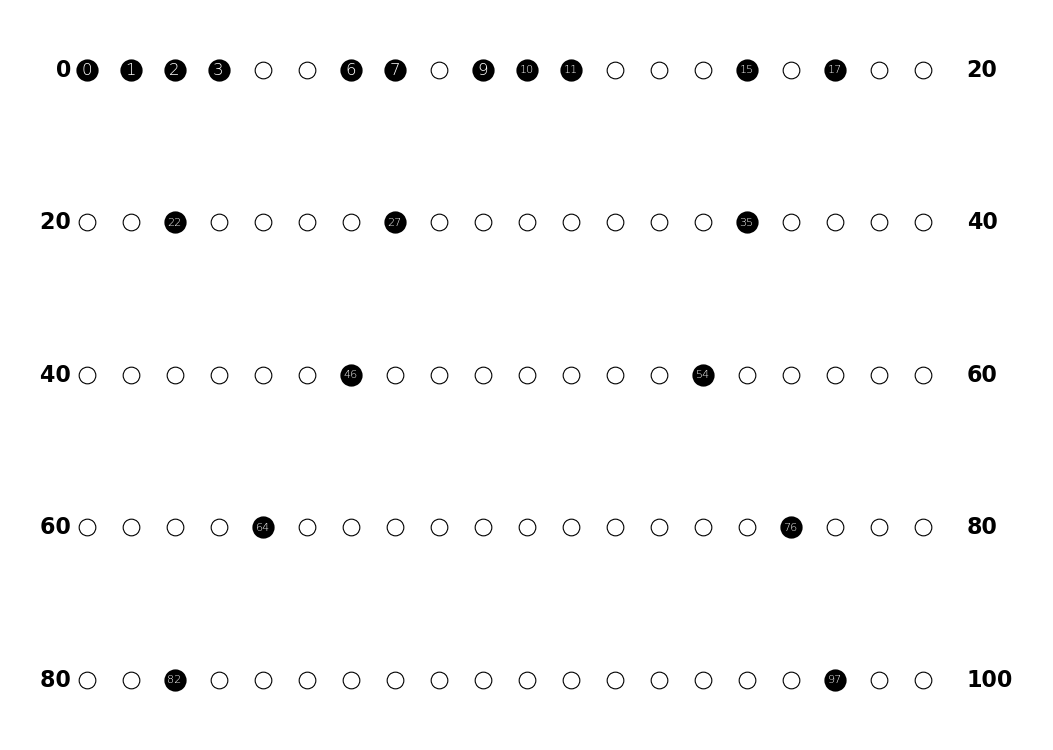

In [144]:
plotpoints = cs.MyPlot()

plotpoints.plot_list(set1,total_number_of_indices,rows=5)

#a poisson random variable with mean lmbd is given by
#P(k) = lmbd^k * e^(-lmbd) / k!
#where k is the number of events and lmbd is the average number of events per unit time
#The probability of the first event is given by
#P(0) = e^(-lmbd)
#The probability of the current event is given by
#P(k) = P(k-1) * u
#where u is a random number between 0 and 1
#The number of events is given by
#k = 1 + sum(P(k-1) * u)
#where u is a random number between 0 and 1

In [145]:
import scipy.fftpack as spfft
import numpy as np
import matplotlib.pyplot as plt

import HQStyle
HQStyle.import_all()

/home/gsilvi/Projects/hqstyle/HQStyle/basic_imports.py:39: UserWarning: Trying to register the cmap 'mutedmagma' which already exists.
  register_cmap(tmp_name, cmap)


Now let’s fit two lines to the data_point samples. For the first line, we’ll use the L1 norm as the criterion for a good fit; for the second line, we’ll use the L2 norm.

Now, let’s get a tad crazy and add some outliers. In other words, let’s perturb a couple of the points, moving them far away from the lines. This isn’t actually all that out of the ordinary if you think about it. Outliers frequently occur in real world data_point, causing all kinds of headaches.

## Reconstruction of a Simple Signal


Expecte frequencies: [0.87890625, 0.09765625, 0.8681640625]


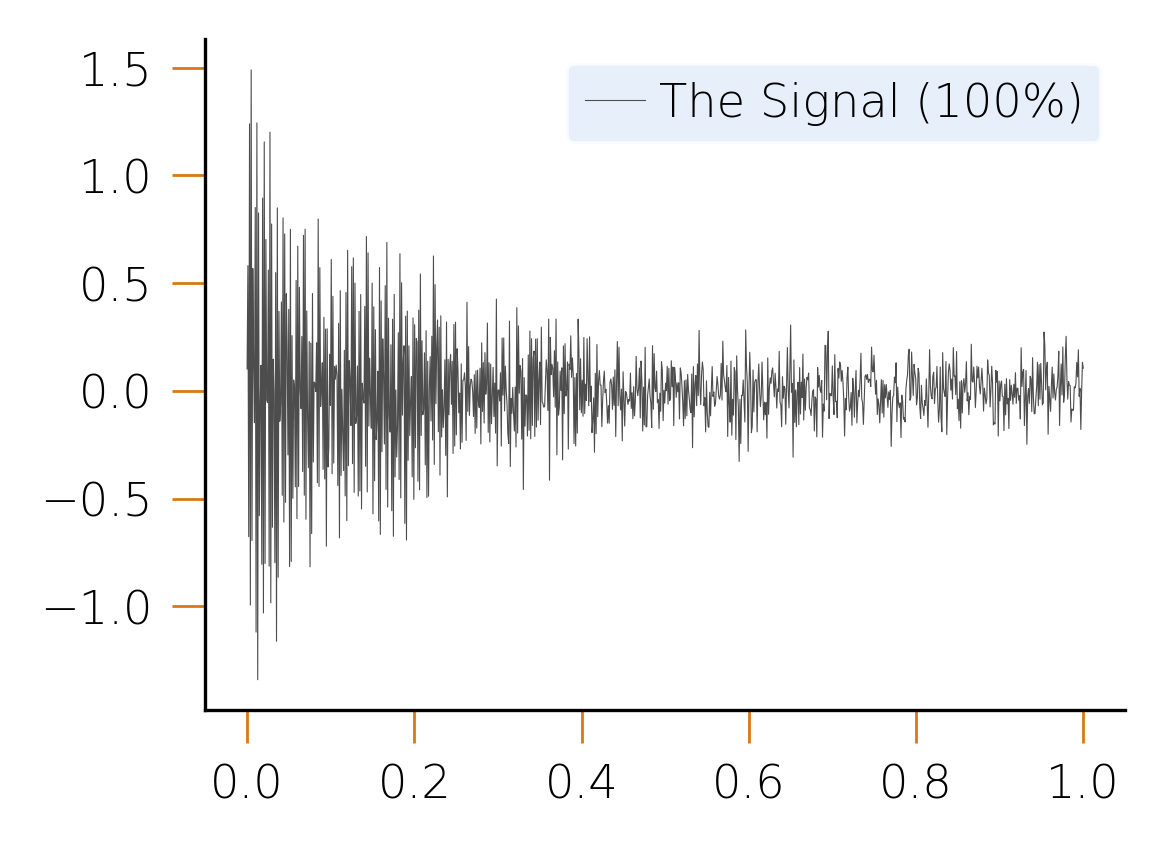

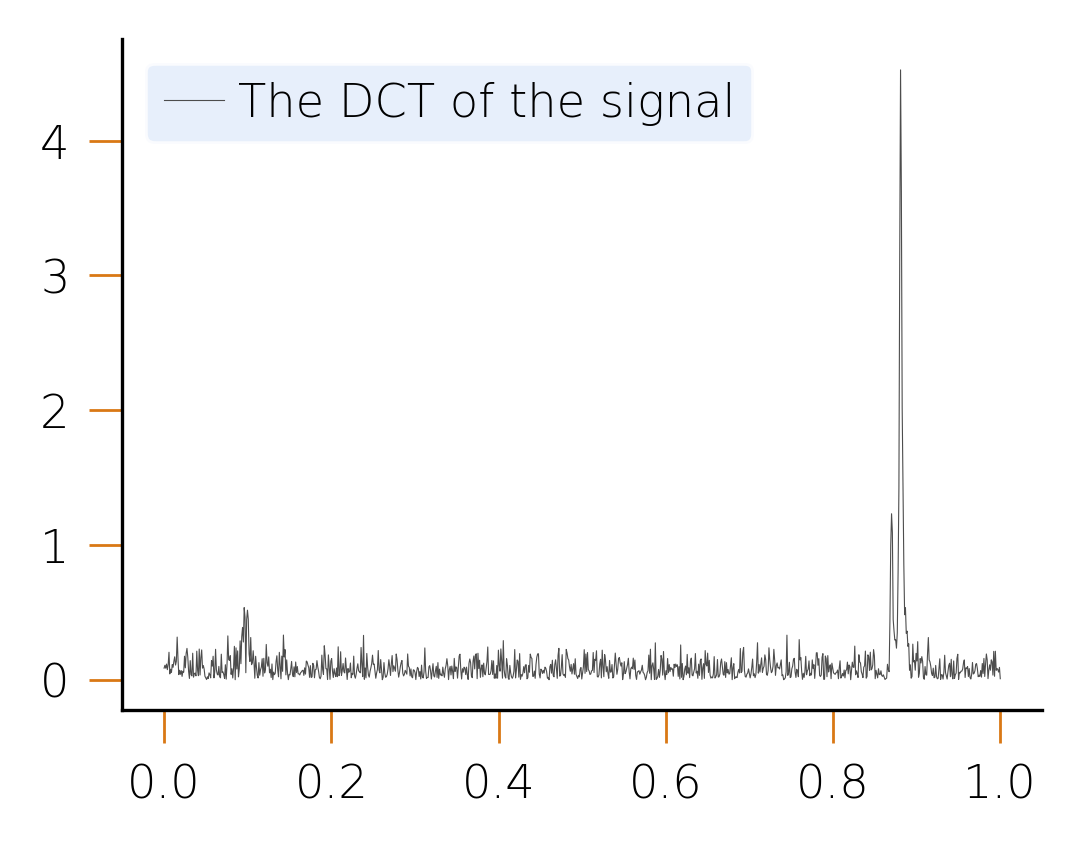

In [146]:

# sum of n sinusoids
n_t = 1024 # number of samples
t_max =1 # maximum time
frequencies = [900, 100, 889]
amplitudes = [1, 0.2, 0.3]

t = np.linspace(0, t_max, n_t) # time vector
y = np.zeros(n_t)

for i in range(len(frequencies)):
    y += amplitudes[i]*np.sin(frequencies[i] * np.pi * t) # combine the sinusoids into one signal

#add exponentian to damp the signal
r2 = 5
y = y * np.exp(-t*r2)
# add gaussian noise
y += np.random.normal(0, 0.1, n_t)

print('Expecte frequencies:',[freq/n_t for freq in frequencies])


yt = spfft.dct(y, norm='ortho') # DCT of the signal, Discrete Cosine Transform ,Fourier Transform



plt.plot(t, y, linewidth=.2, label='The Signal (100%)')
plt.legend()
plt.figure()
plt.plot(t, np.abs(yt), linewidth=.2, label='The DCT of the signal')
plt.legend()
# plt.gca().invert_xaxis()
# plt.show()

Now imagine sampling some small % of the temporal signal (see below)

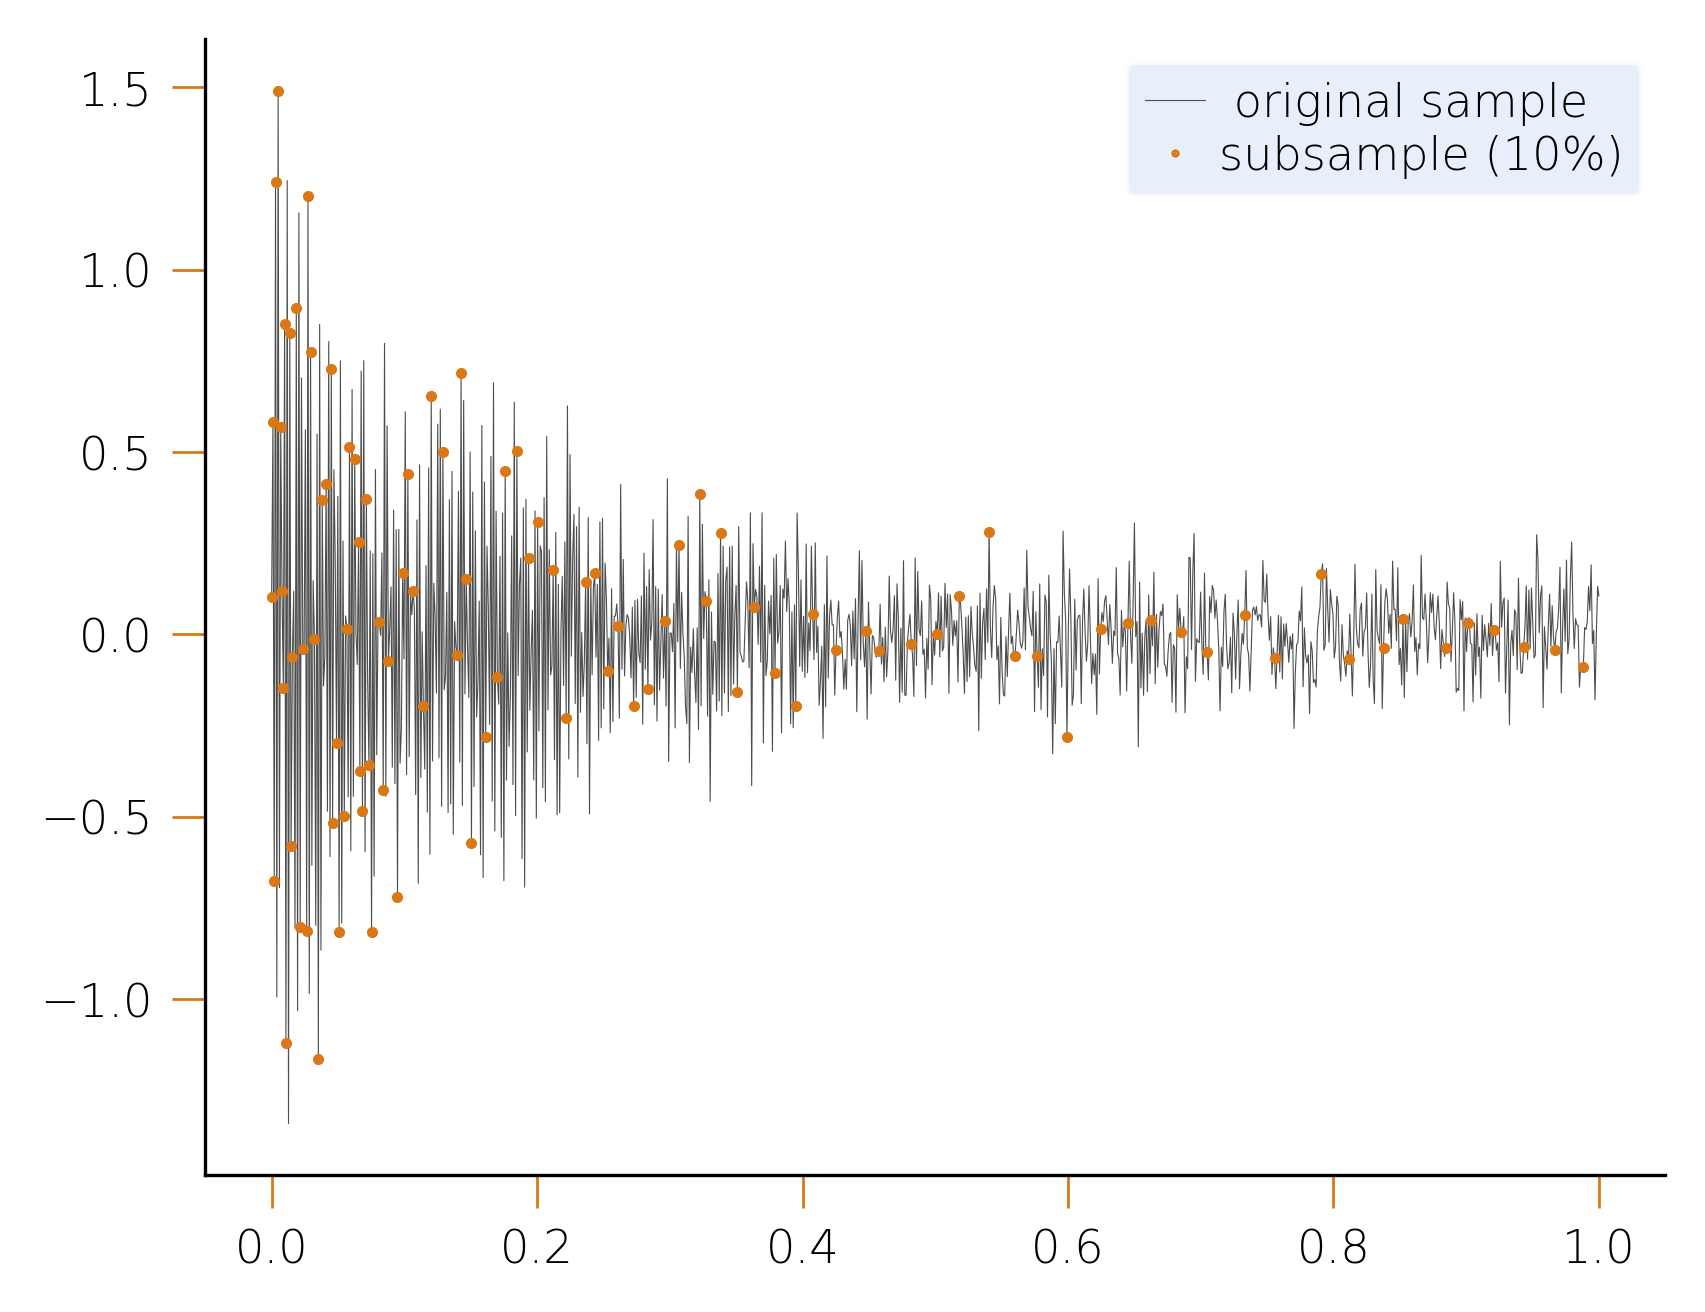

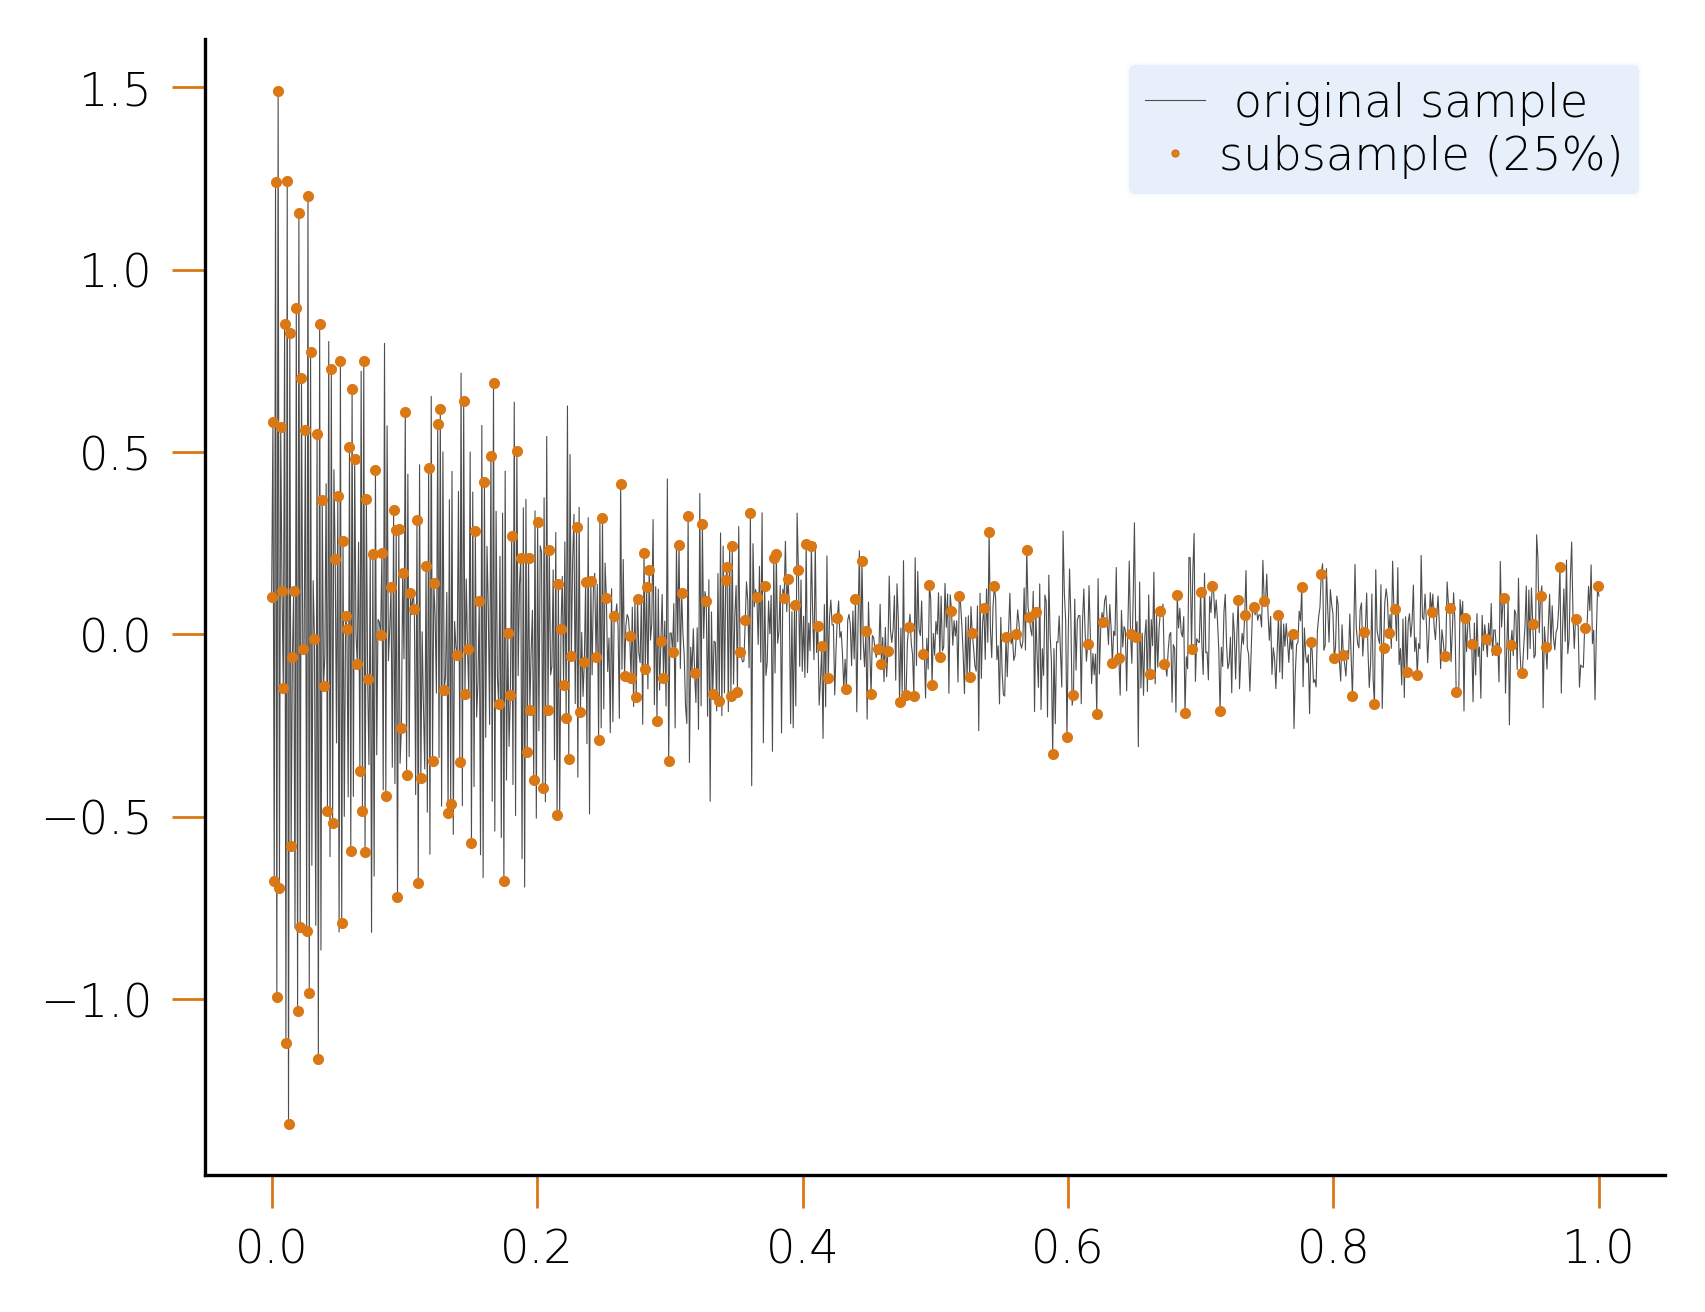

In [147]:
import compressed_sensing as cs
# extract small sample of signal
percentages = [10,25]
subtime_set =[]
subsignal_set =[]
subsignal_set_padded =[]
index_set = []

for percentage in percentages:

    number_of_samples = int(n_t*percentage/100) # 10% sample
    subset = cs.PoissonNumbers(number_of_samples,n_t, usenumpy=True)
    
    t2 = t[subset] #time vector resampled
    y2 = y[subset] # signal resampled
    y3 = [0]*n_t # signale resampled but padded
    for i in subset:
        y3[i]=y[i]
    index_set.append(subset)
    subtime_set.append(t2)
    subsignal_set.append(y2)
    subsignal_set_padded.append(y3)

    # set figure size to 10,5
    plt.figure(figsize=(5,4))
    plt.plot(t, y, linewidth=.2,  label=' original sample')
    plt.plot(t2, y2, linewidth=.2, marker='o',markersize=1, linestyle='None', label='subsample ('+str(percentage)+'%)')

    plt.legend()
    #plt.xlim(0,0.025)
    



In [148]:

# create idct matrix operator in order to perform inverse DCT
A = spfft.idct(np.identity(n_t), norm='ortho', axis=0) 
# Inverse Cosine Discrete Transform is the inverse of the DCT. 
# DCT is a discrete transform of the signal from the time domain to the frequency domain.

if n_t<=1000:
    fig = plt.figure(figsize=(10,10))
    plt.imshow(A)

In [149]:

# do L1 optimization
use_padded = False
results_set = []
print('total points:',n_t)
all_subsignals = []

for i,subset in enumerate(index_set):
    print('\n\nSubset:',i+1,'/',len(index_set),'(',percentages[i],'%)','(',len(subset),'samples)')

    if use_padded:
        Asub = A
        subsignal = subsignal_set_padded[i] 
    else:
        Asub = A[subset] # extract small sample of idct matrix, set1 is the indices of the subsample
        subsignal = subsignal_set[i]

    
    vx = cvx.Variable(n_t) # variable for the coefficients

    objective = cvx.Minimize(cvx.norm(vx, 1)) # L1 norm to minimize, we use L1 because we want a sparser solution for vx (fourier coefficients)
    constraints = [Asub*vx == subsignal] # equality constraint Ax = y , y2 is the small sample of the signal
    prob = cvx.Problem(objective, constraints) # create problem
    result = prob.solve(verbose=False) # solve problem

    results_set.append(vx.value) # save the coefficients

total points: 1024


Subset: 1 / 2 ( 10 %) ( 102 samples)


/home/gsilvi/miniforge3/envs/MERCK/lib/python3.9/site-packages/cvxpy/expressions/expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 25 times so far.

  warnings.warn(msg, UserWarning)




Subset: 2 / 2 ( 25 %) ( 256 samples)


/home/gsilvi/miniforge3/envs/MERCK/lib/python3.9/site-packages/cvxpy/expressions/expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 26 times so far.

  warnings.warn(msg, UserWarning)


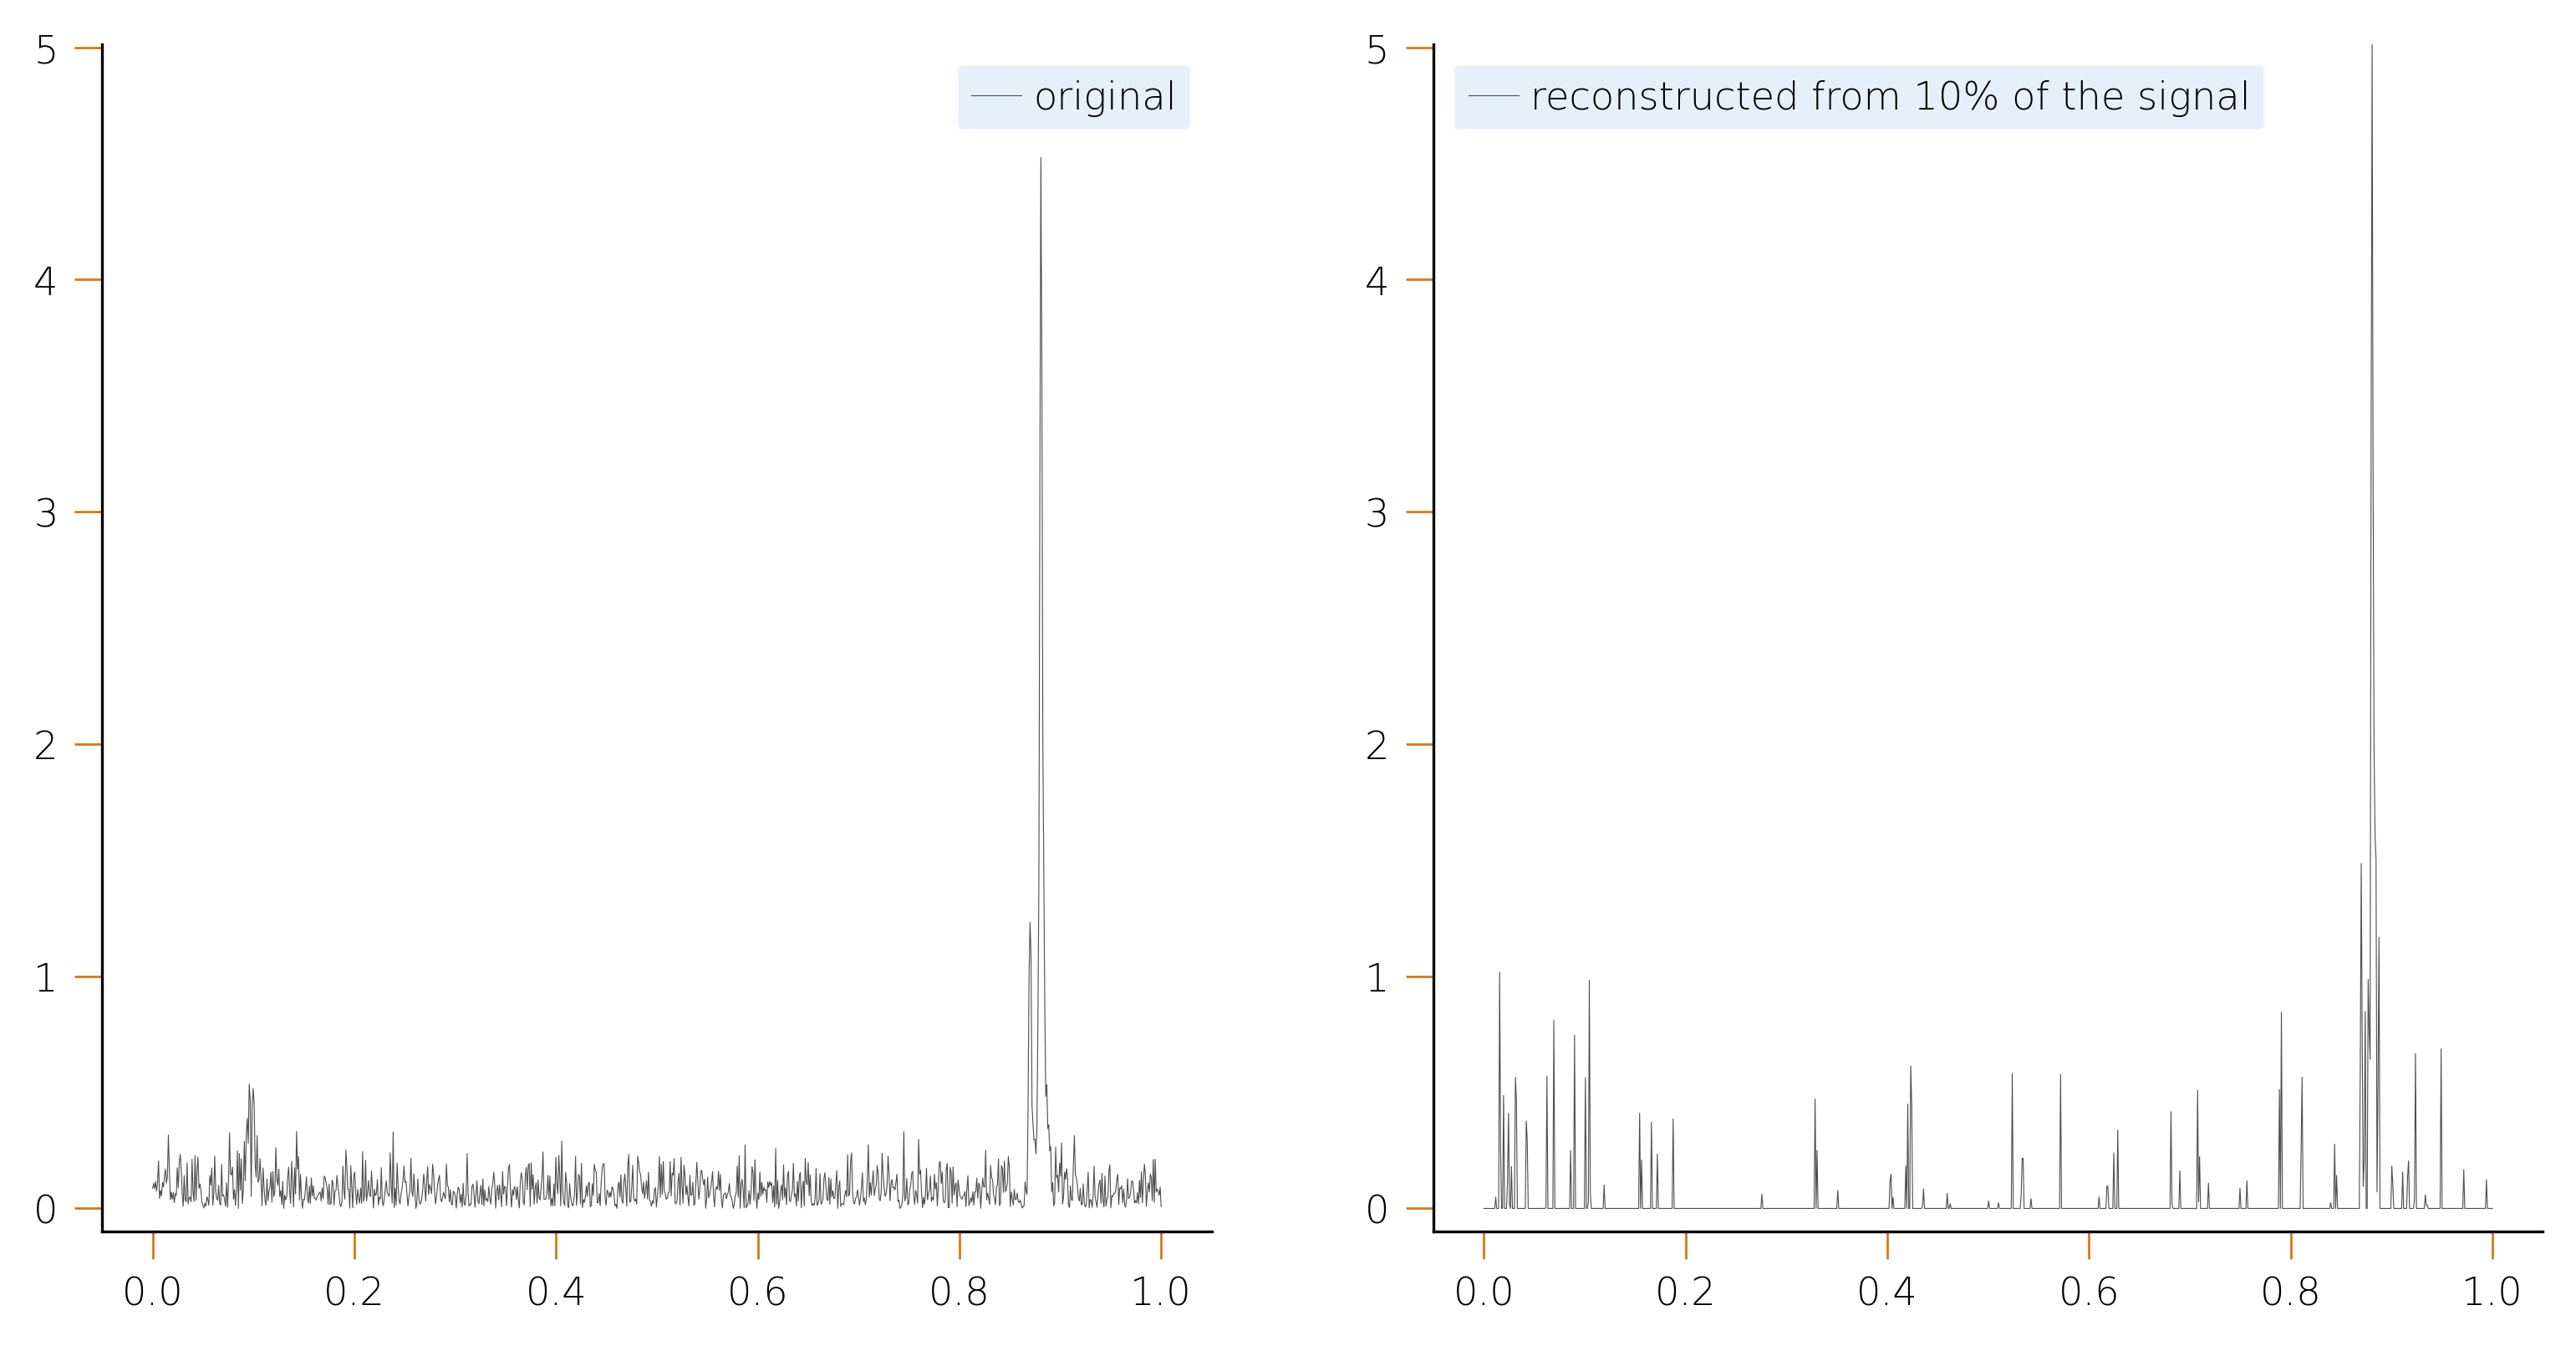

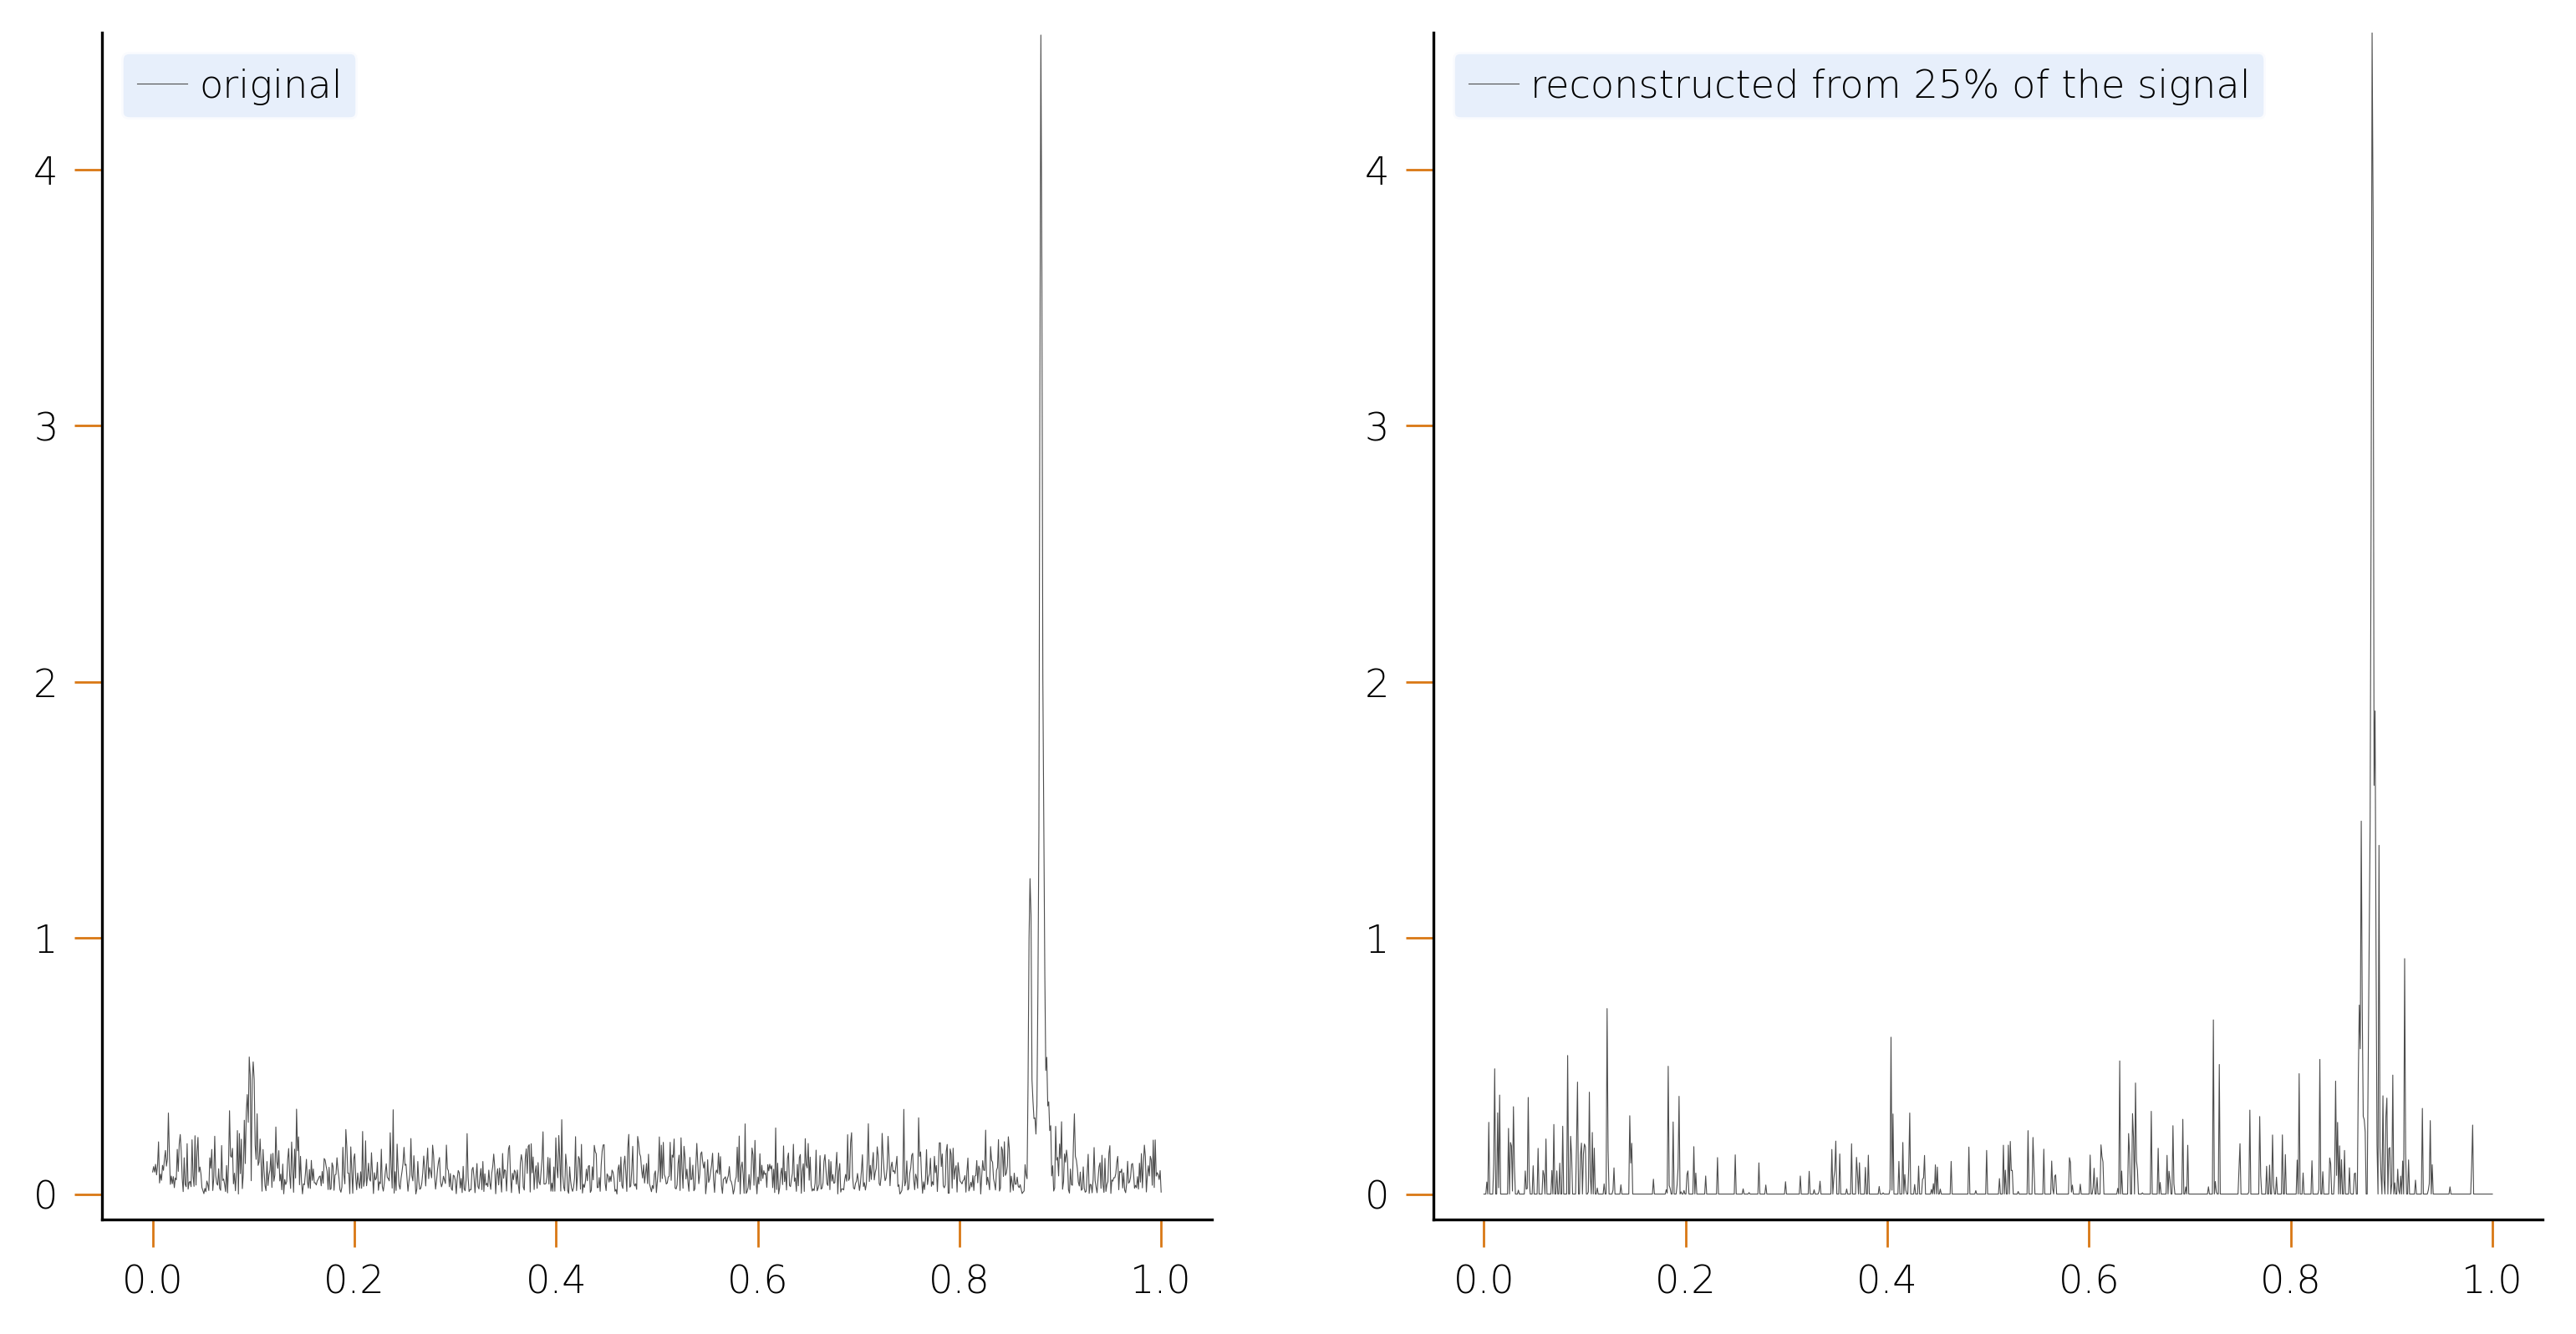

In [150]:
for i,vx in enumerate(results_set):

    #make a new figure and plot 2 subplots 
    fig = plt.figure(figsize=(10,5))
    ax1 = fig.add_subplot(121) #the argument is the number of rows and columns of the subplot
    ax2 = fig.add_subplot(122)
    #plot yt in ax1 and vx.value in ax2
    ax1.plot(t, np.abs(yt), linewidth=.2, label='original')
    ax2.plot(t, np.abs(vx), linewidth=.2, label='reconstructed from '+str(percentages[i])+'% of the signal')
    #add legend
    ax1.legend()
    ax2.legend()

    # find the max and min value of both signal
    max_yt = np.max(np.abs(yt))
    # min_yt = np.min(yt)
    max_vx = np.max(np.abs(vx))
    # min_vx = np.min(vx)
    #find the max between the two signals
    max_value = max(max_yt, max_vx)
    min_value = -0.1
    #set the limits of the axes
    ax1.set_ylim(min_value, max_value)
    ax2.set_ylim(min_value, max_value)



# plt.plot(yt, linewidth=.2 , label='original')
# plt.figure()
# plt.plot(vx.value, linewidth=.2, label='reconstructed')
# plt.legend()

(0.0, 512.0)

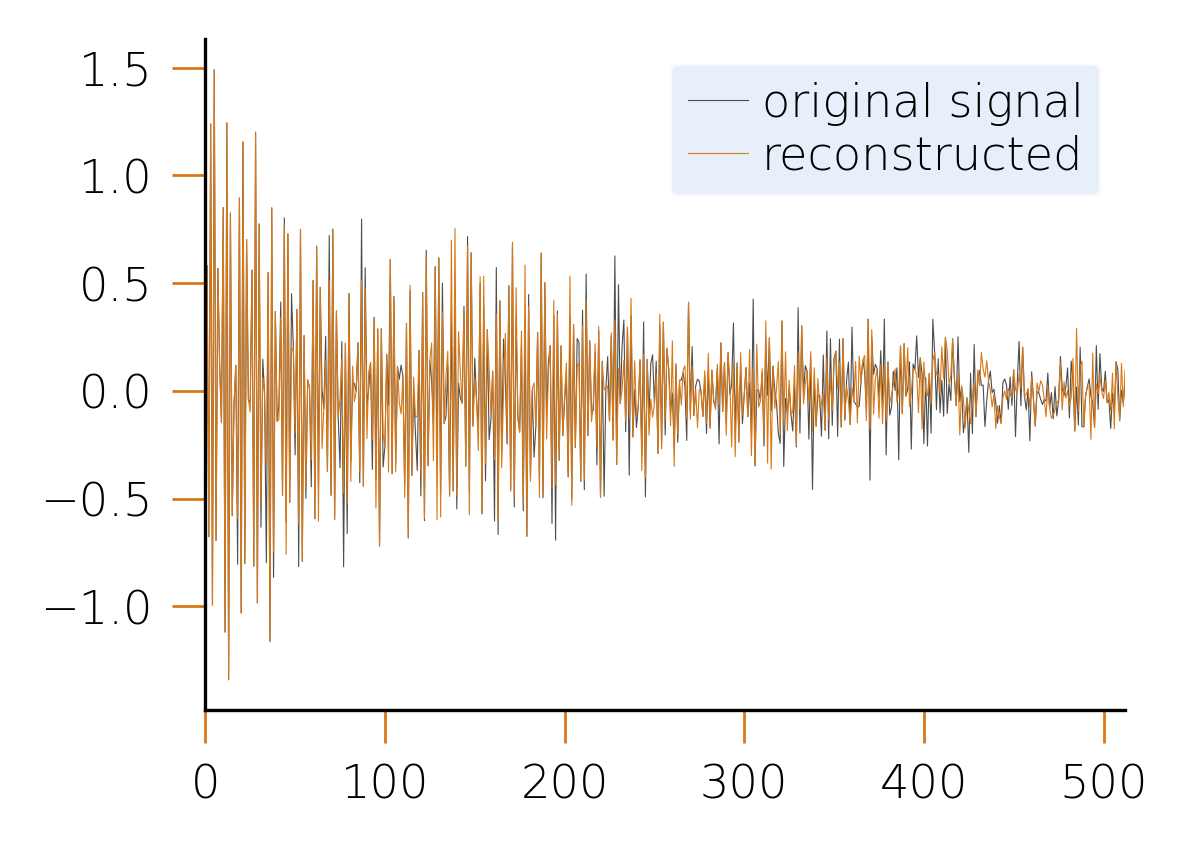

In [151]:
# # reconstruct signal
# x = np.array(vx)
# x = np.squeeze(x)
# sig = spfft.idct(x, norm='ortho', axis=0)

# plt.plot(y, linewidth=.2, label='original signal')
# plt.plot(sig, linewidth=.2, label='reconstructed') 
# plt.legend()
# plt.xlim(0,n_t/2)



case: 2 / 2
Reason to stop: Threshold<1e-07
case: 2 / 2 completed


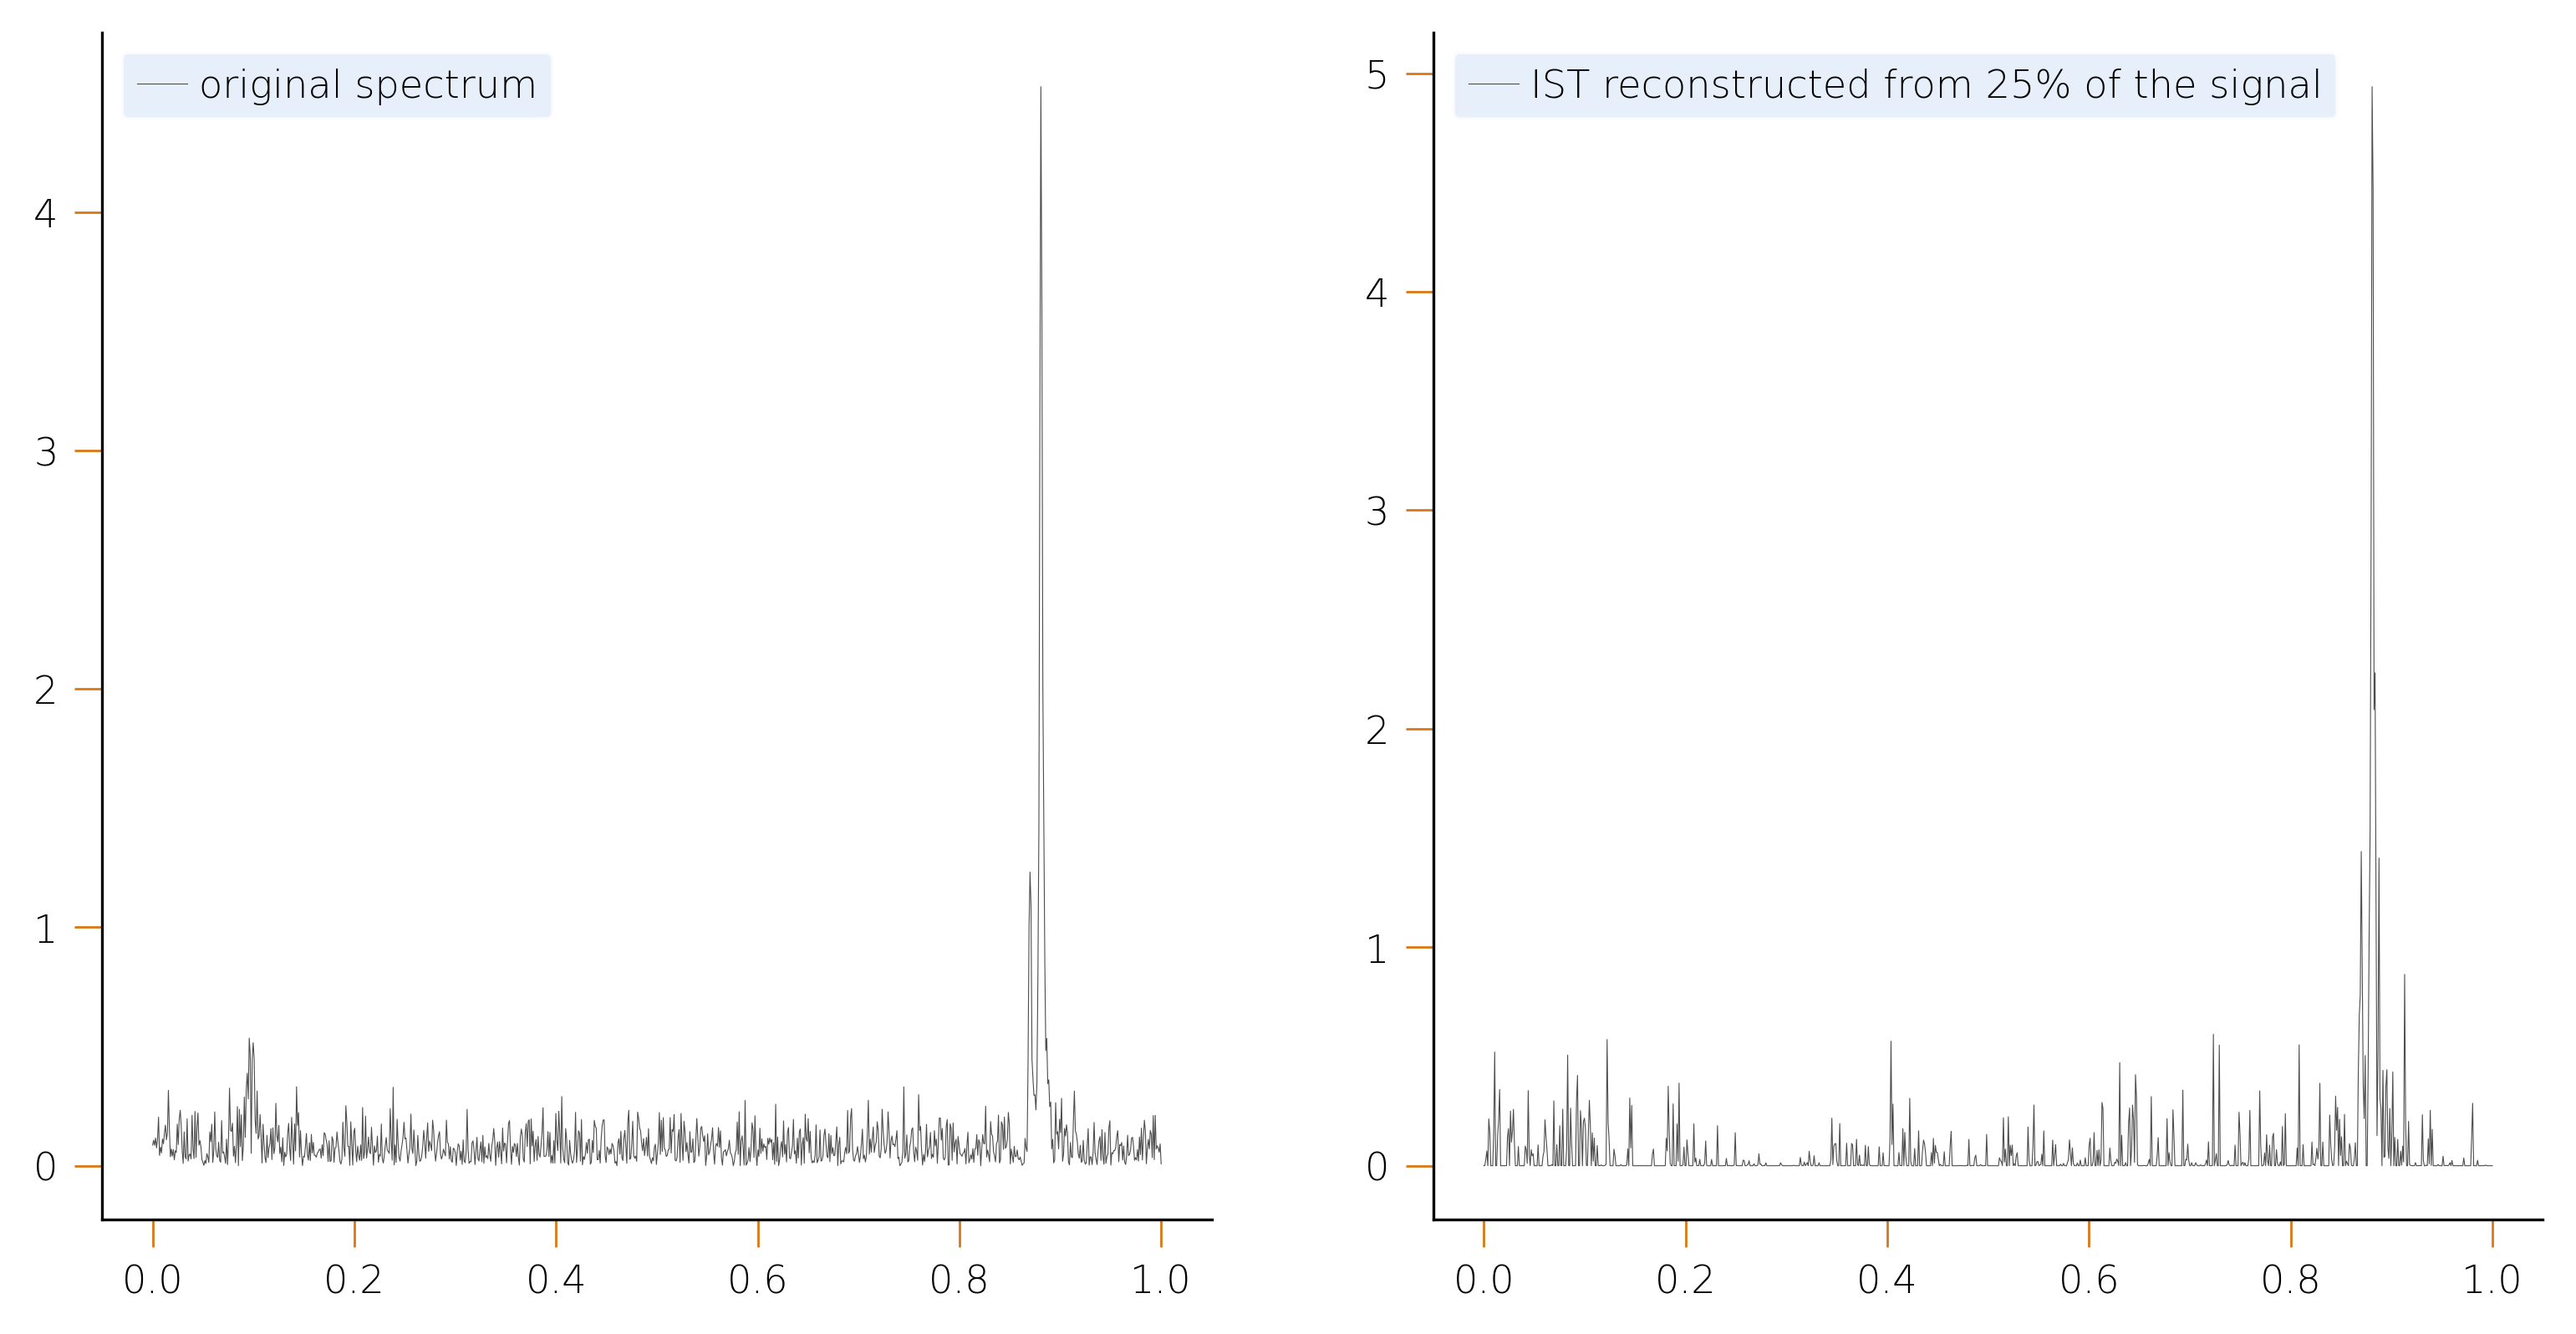

In [158]:
test = cs.ISTrecontruction(decrease_factor=0.95, max_iter=5000, tol=1e-7)
for case in [1]:#range(len(subsignal_set_padded)):
    print('case:',case+1,'/',len(subsignal_set_padded))
    non_index = [i for i in range(n_t) if i not in index_set[case]]
    new_spectrum = test.run(subsignal_set_padded[case],non_index)
    #plot new spectrum
    fig = plt.figure(figsize=(10,5))
    ax1 = fig.add_subplot(121) #the argument is the number of rows and columns of the subplot
    ax2 = fig.add_subplot(122)
    #plot yt in ax1 and vx.value in ax2
    ax1.plot(t, np.abs(yt), linewidth=.2, label='original spectrum')
    ax2.plot(t,np.abs(new_spectrum), linewidth=.2, label='IST reconstructed from '+str(percentages[case])+'% of the signal')
    #add legend
    ax1.legend()
    ax2.legend()
    print('case:',case+1,'/',len(subsignal_set_padded),'completed')
    

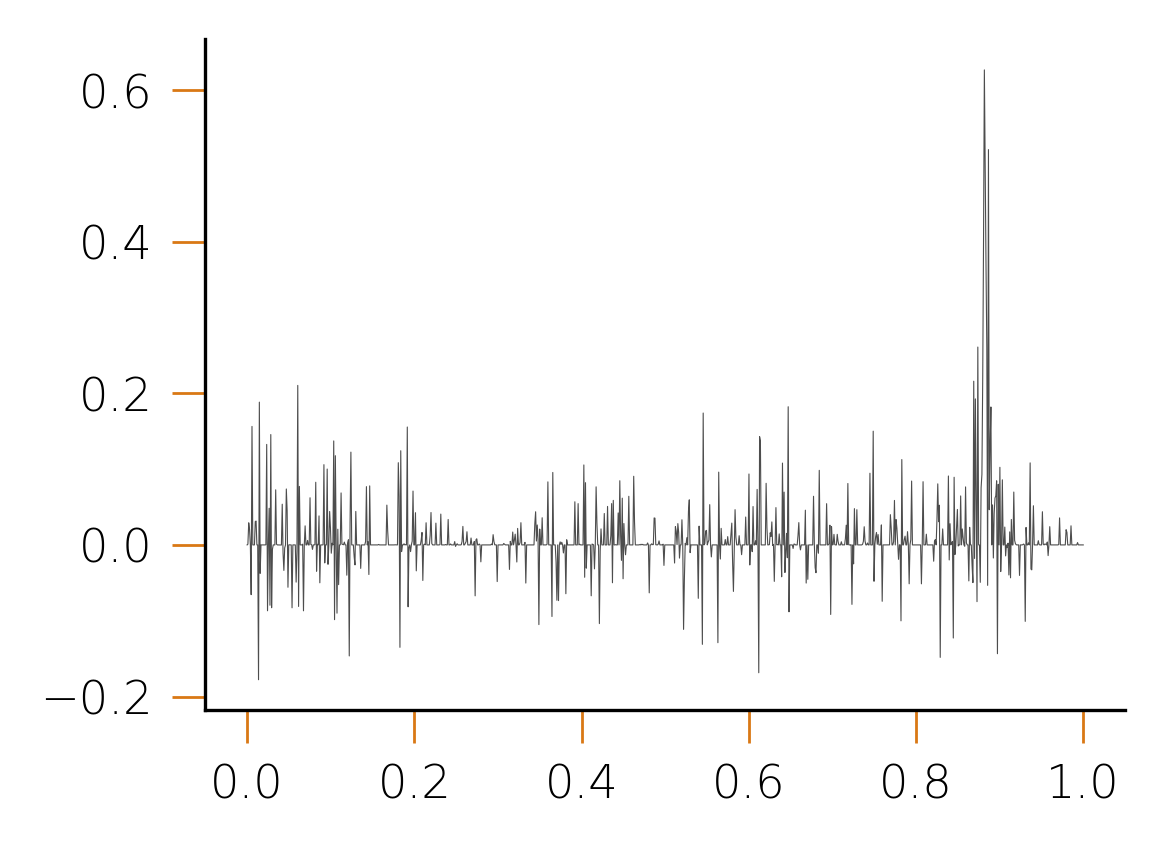

In [160]:
plt.plot(t,np.abs(new_spectrum)-np.abs(results_set[-1]), linewidth=.2, label='A')

# plt.plot(t,np.abs(results_set[-1]), linewidth=.2, label='B')
# plt.plot(t,np.abs(new_spectrum), linewidth=.2, label='C')

Demonstration of the IST method for compressed sensing. 

768 = 768
thr: 1.454050535645238	thr: 1.2922715463500563	thr: 1.1440799586924681	thr: 1.0072445642545538	thr: 0.8794214634405826	thr: 0.7619249872014936	Steps>5


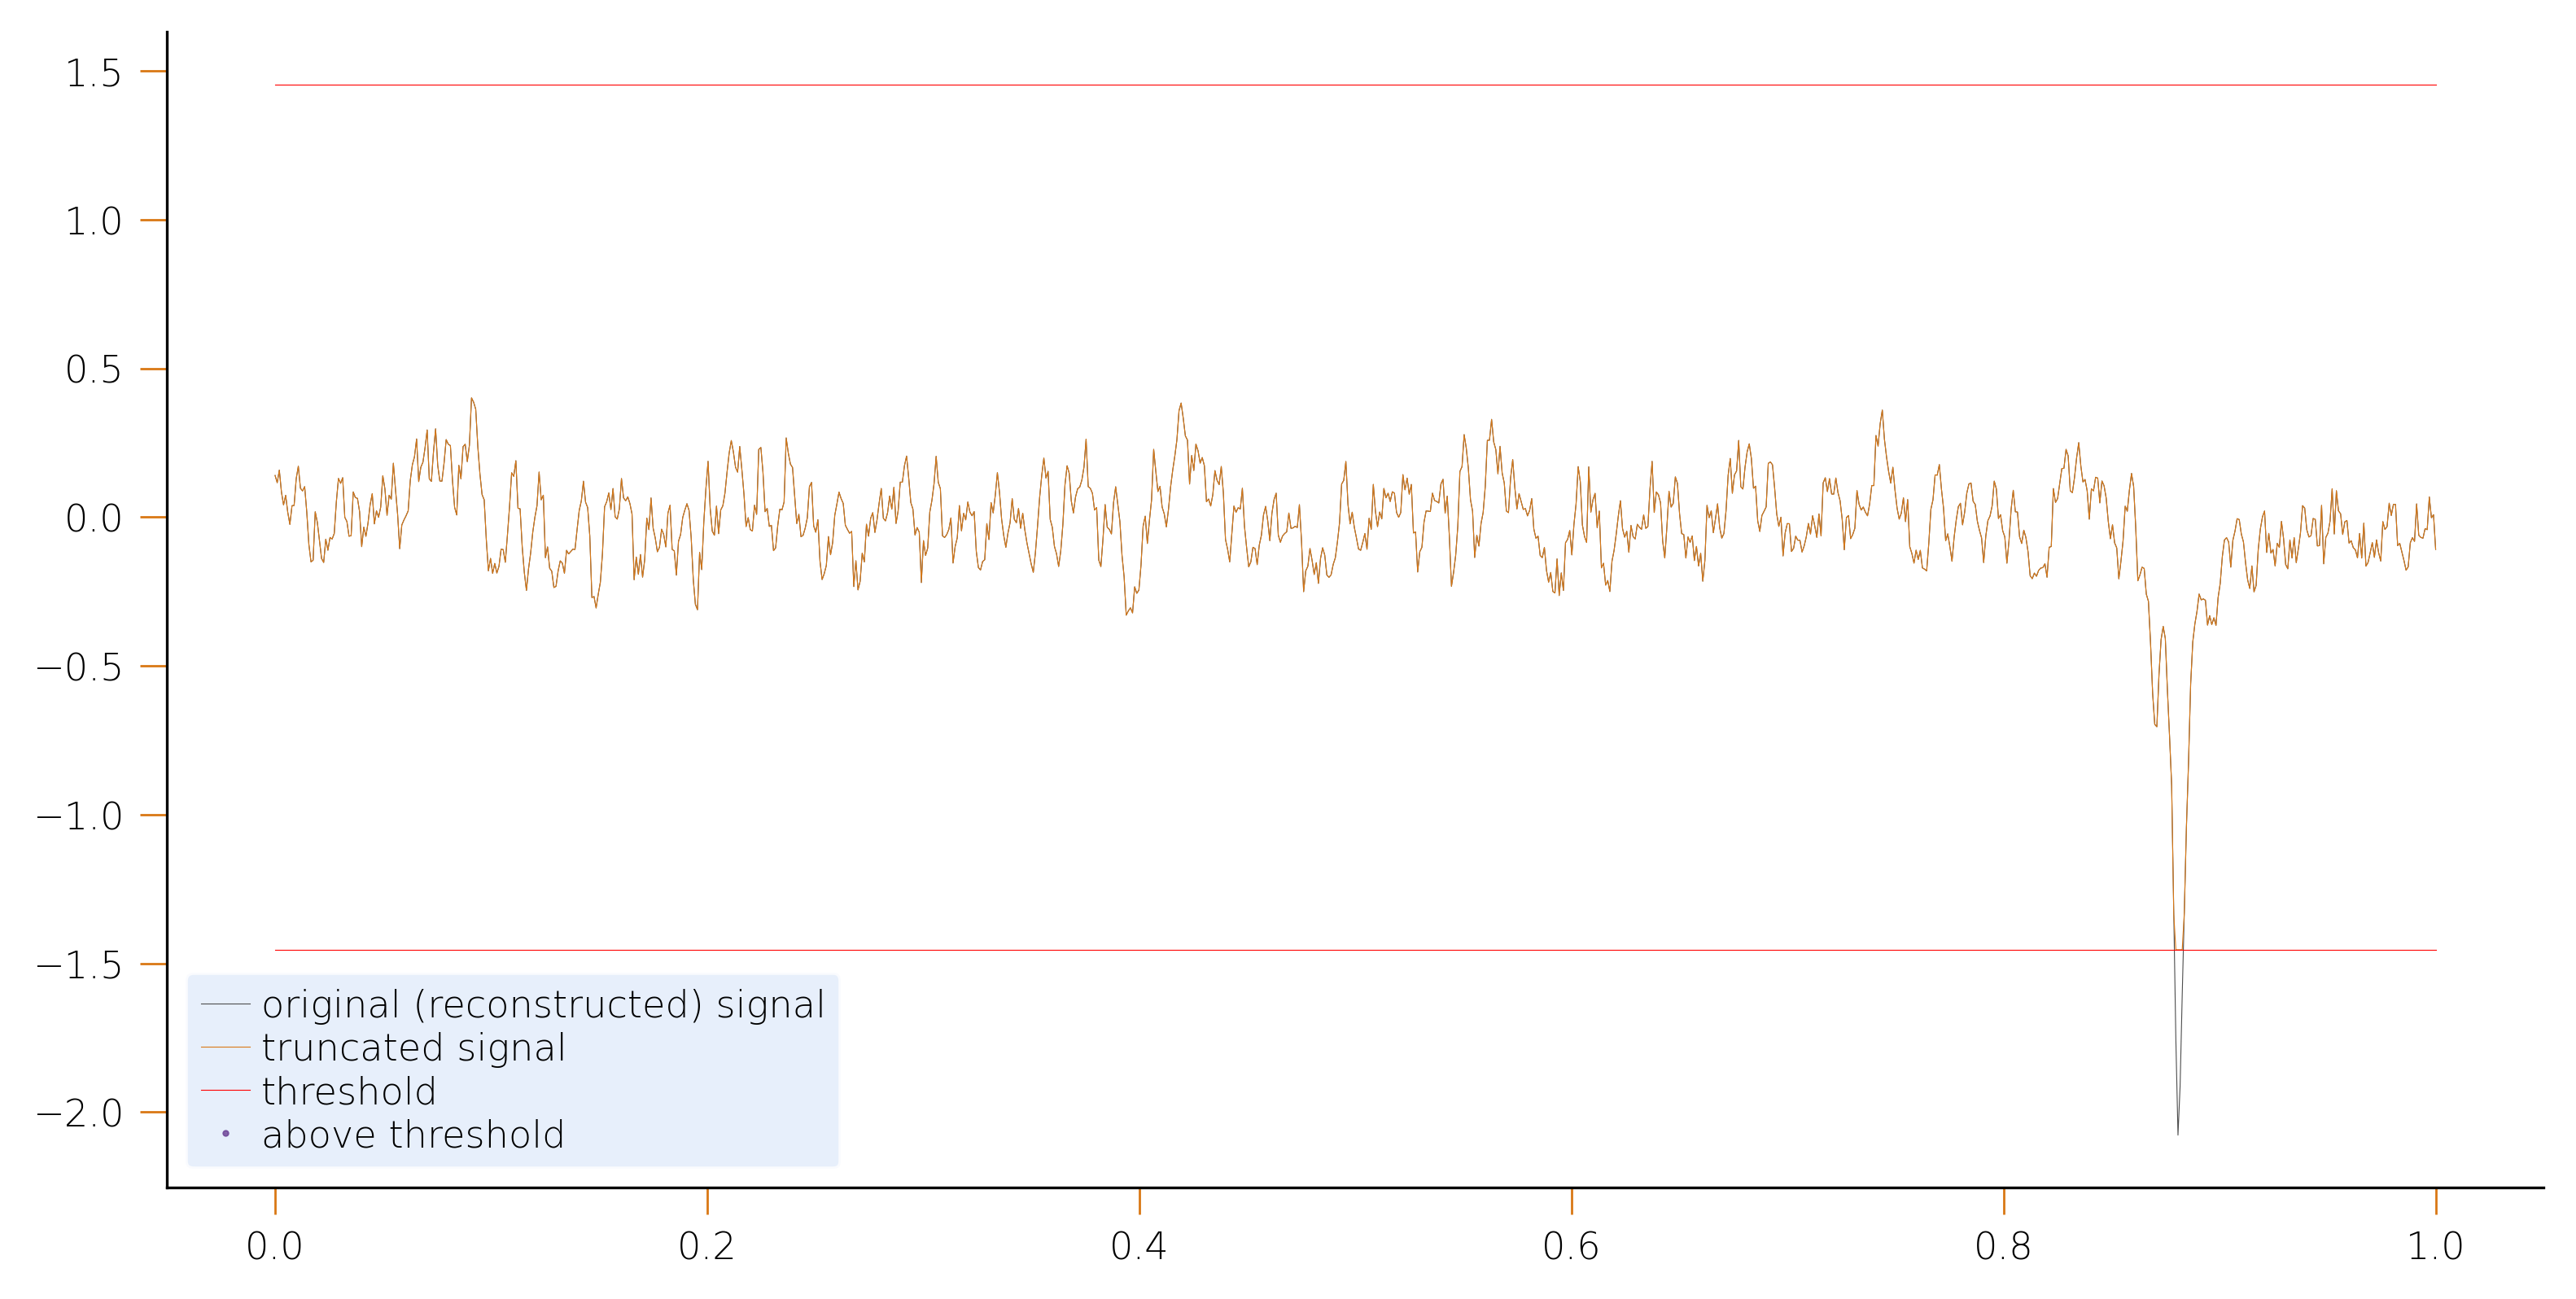

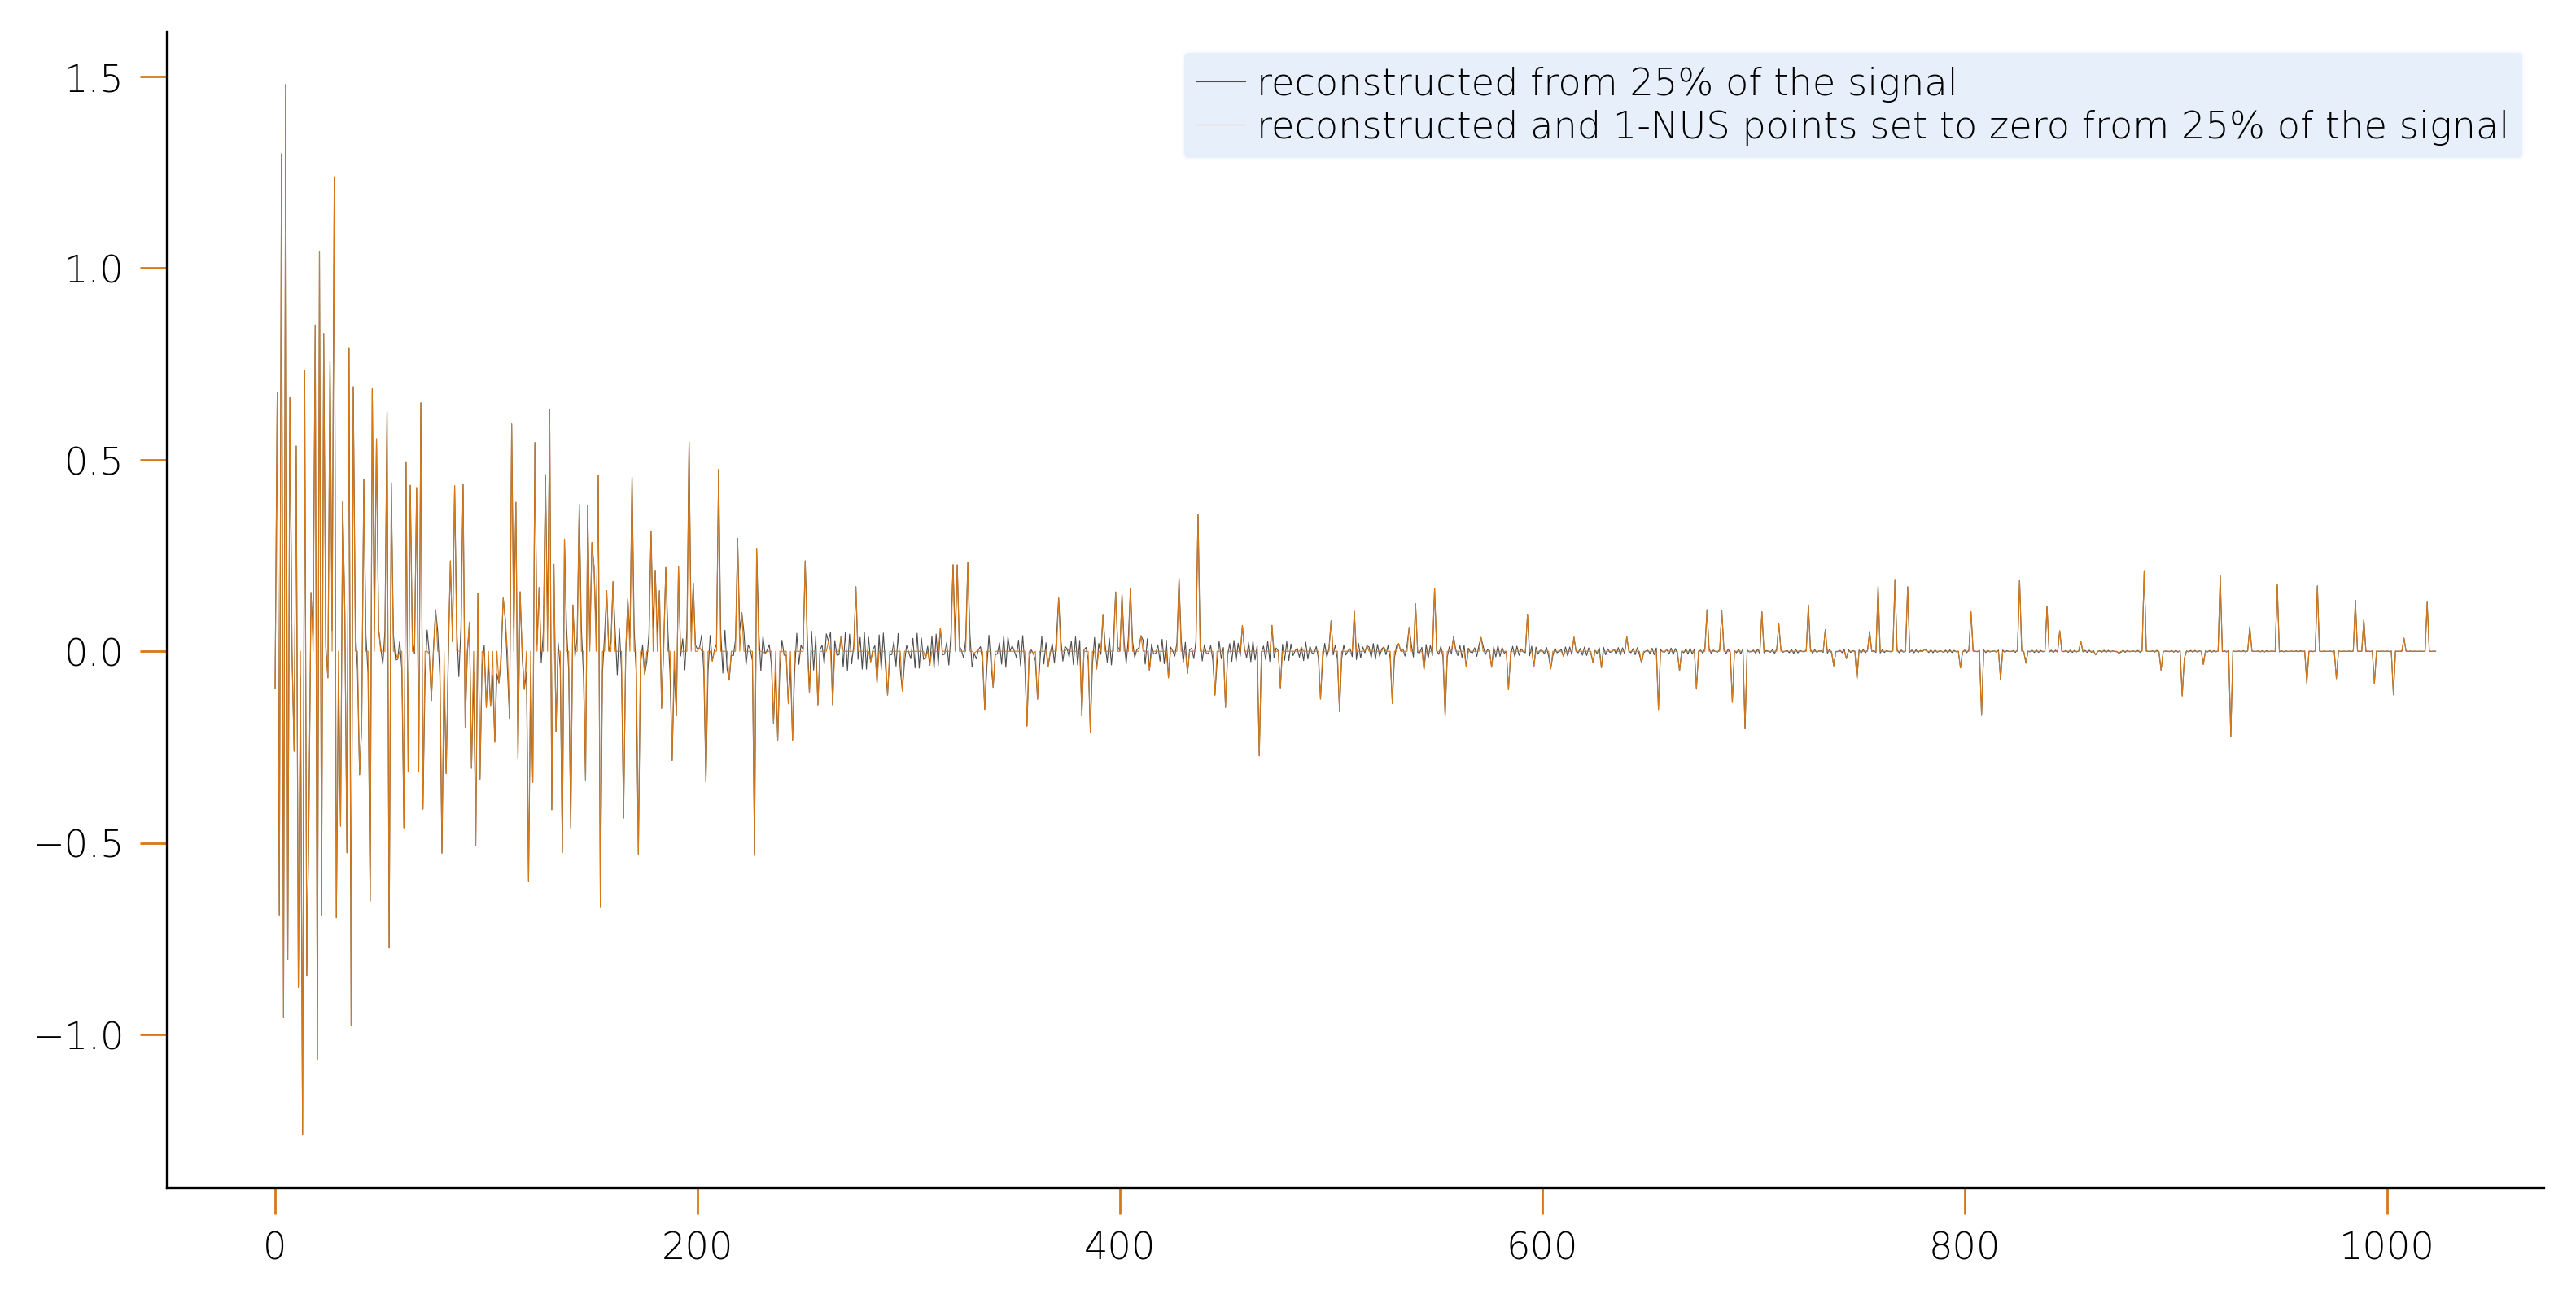

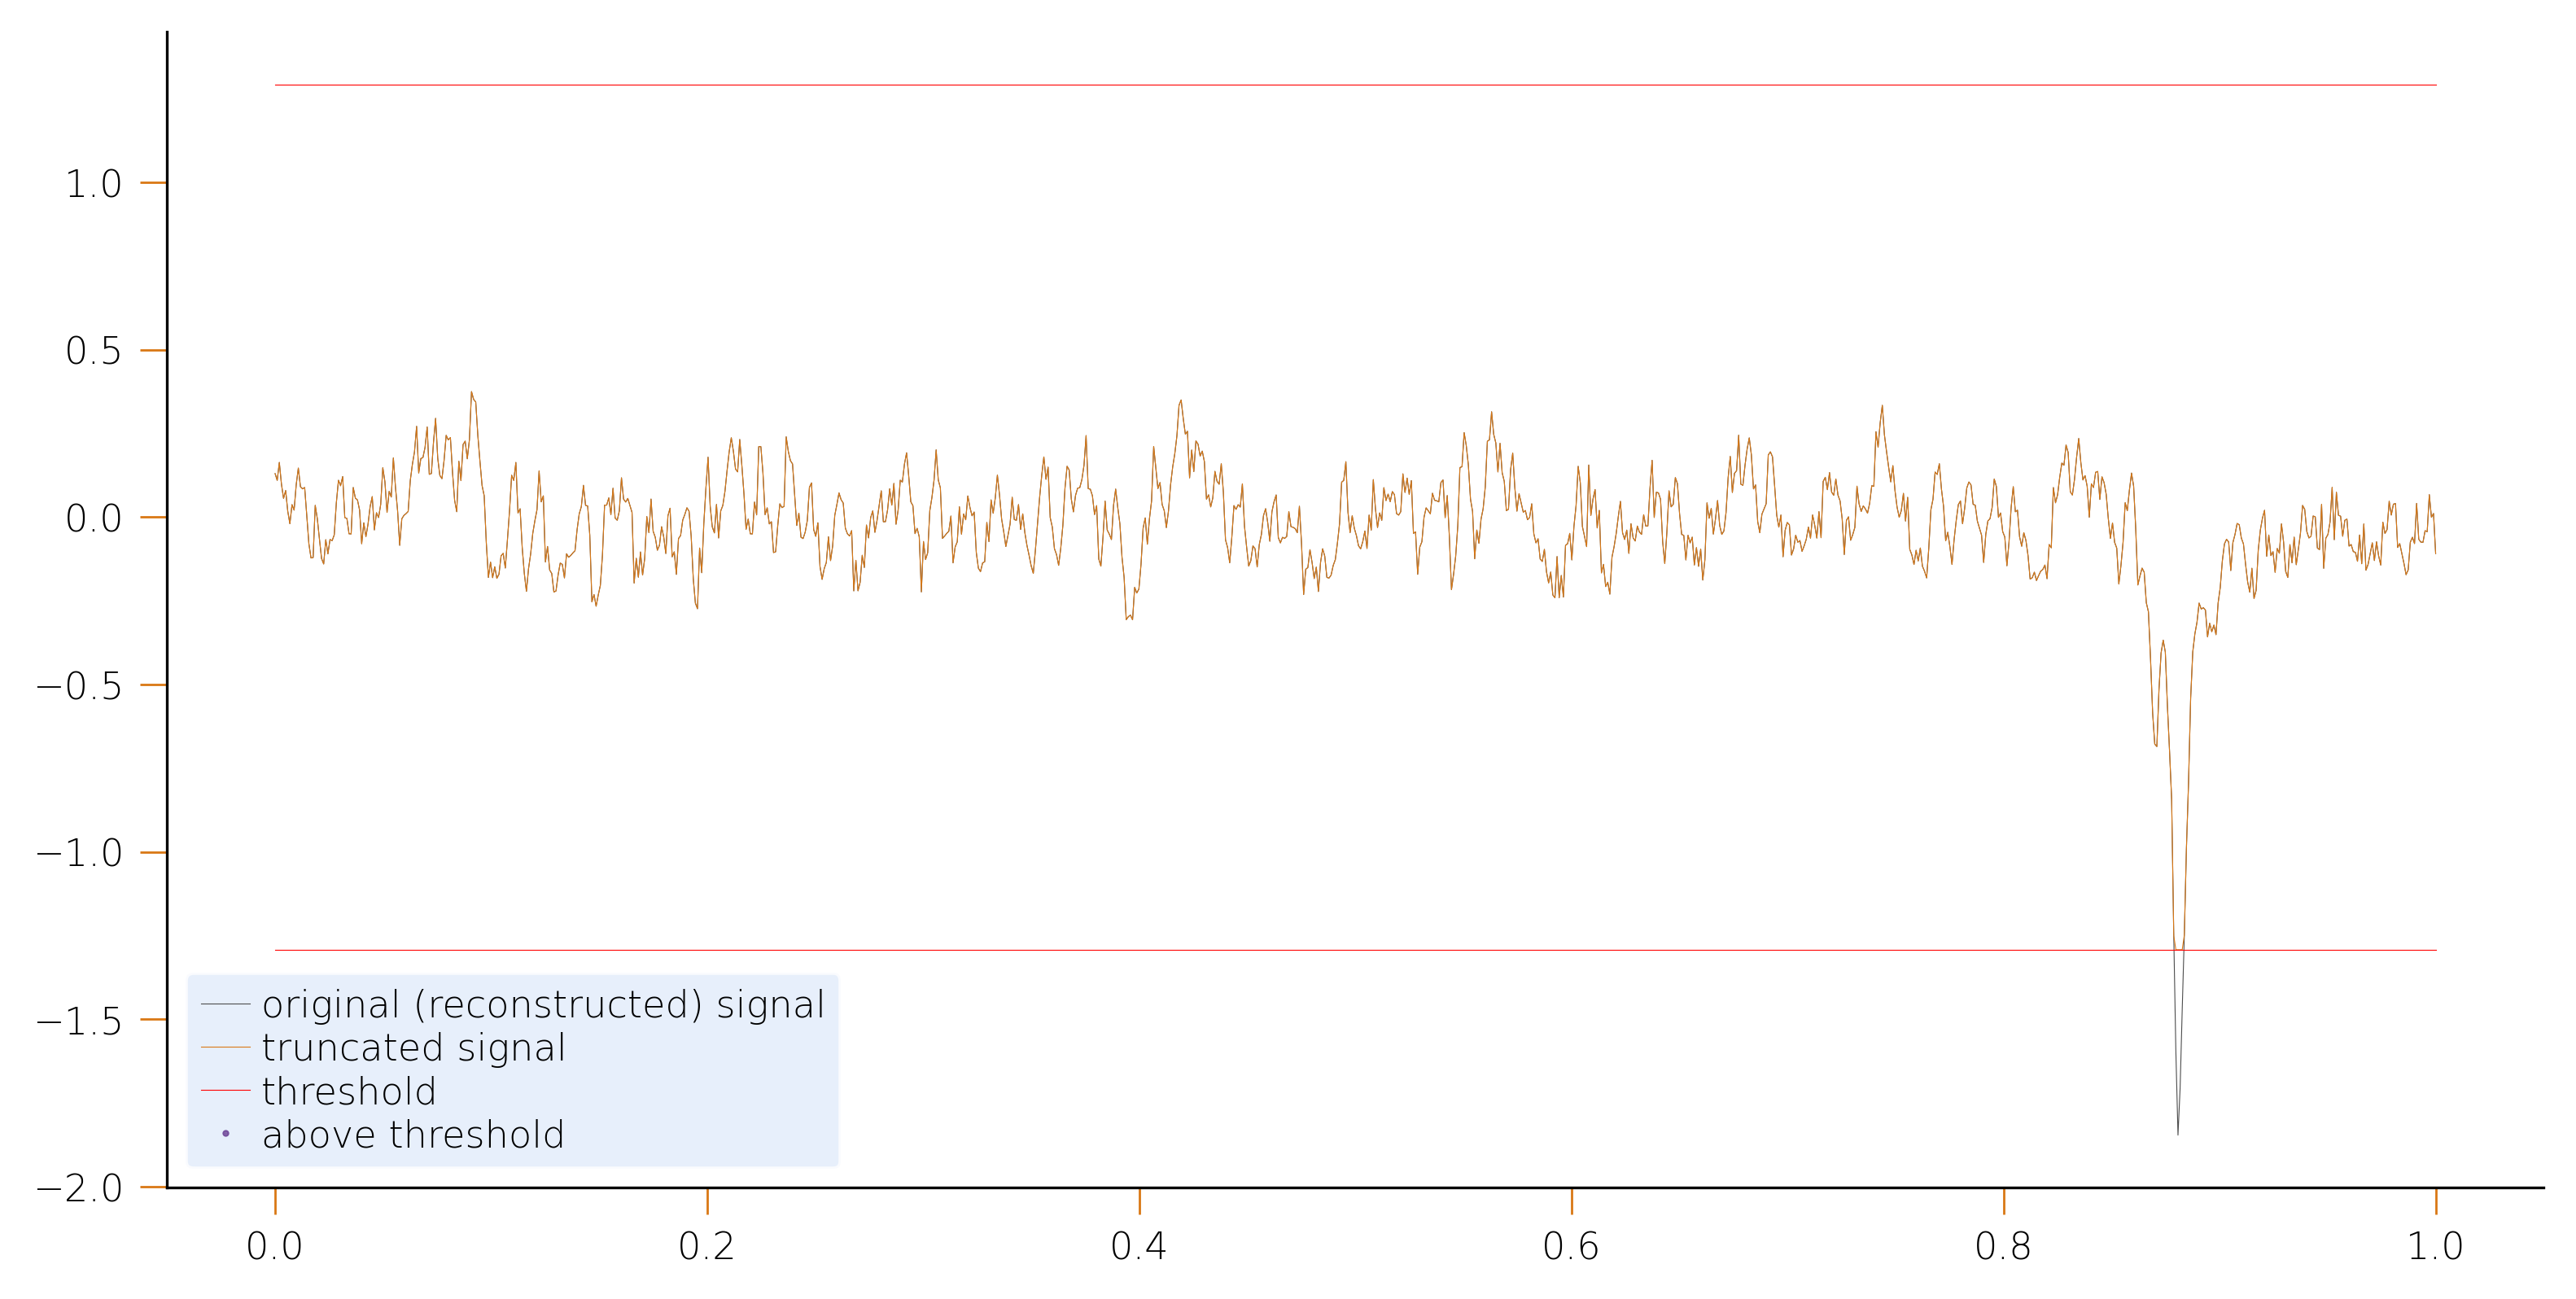

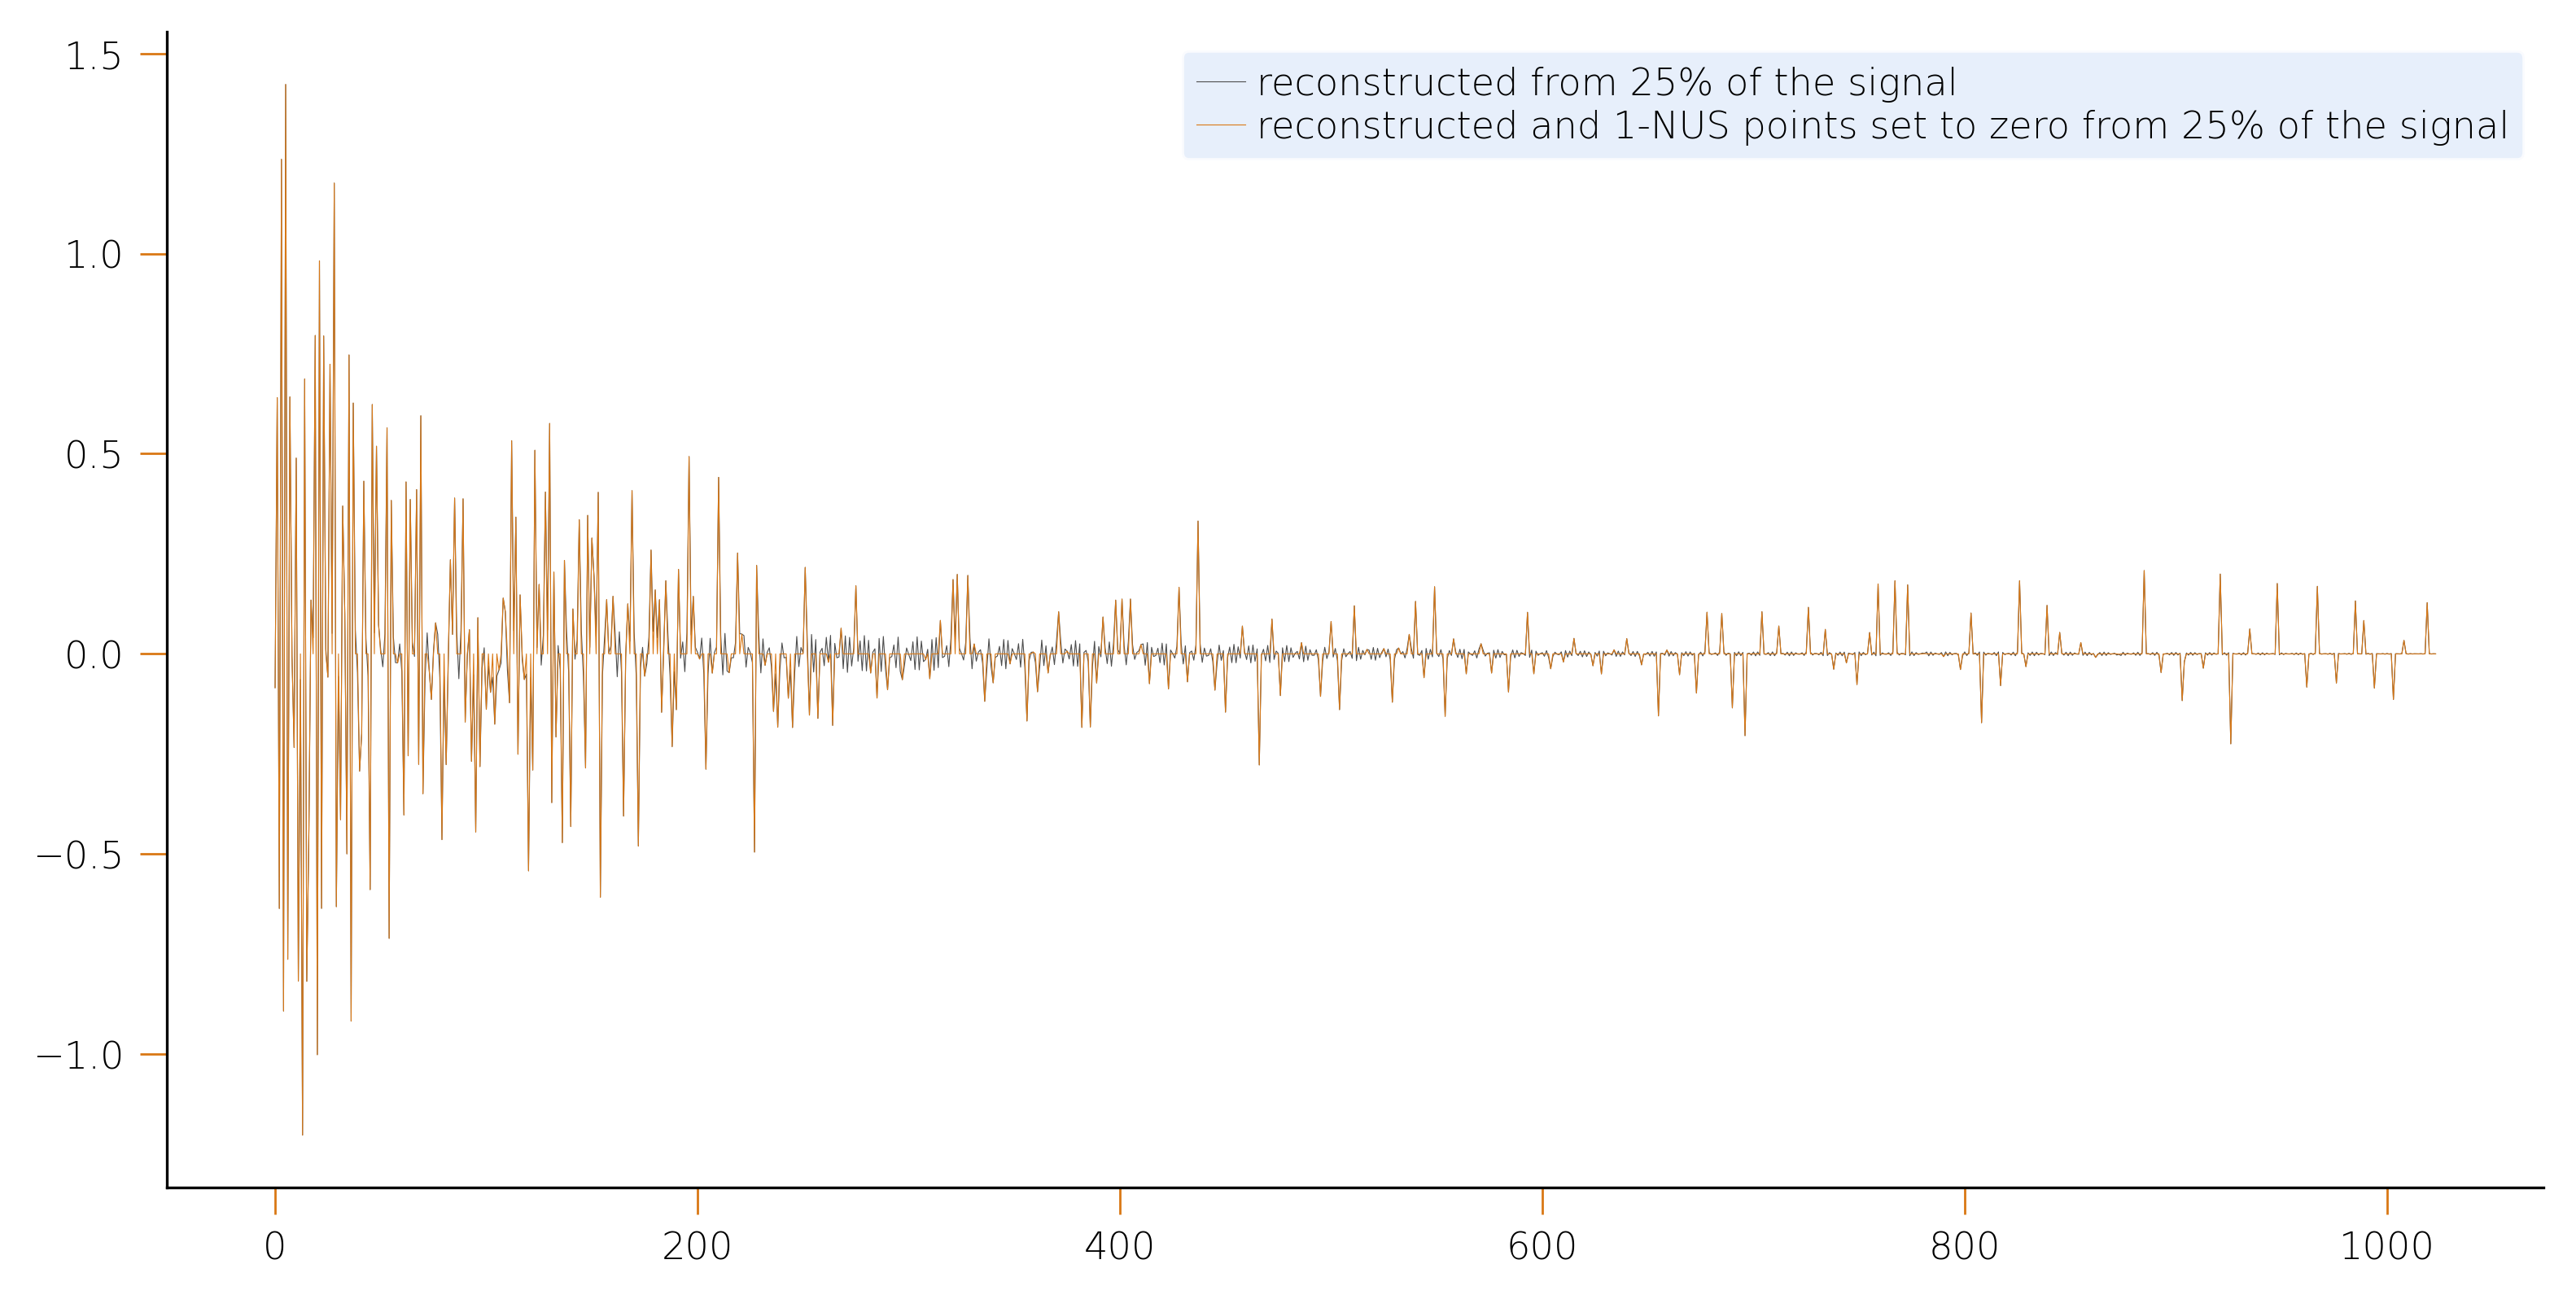

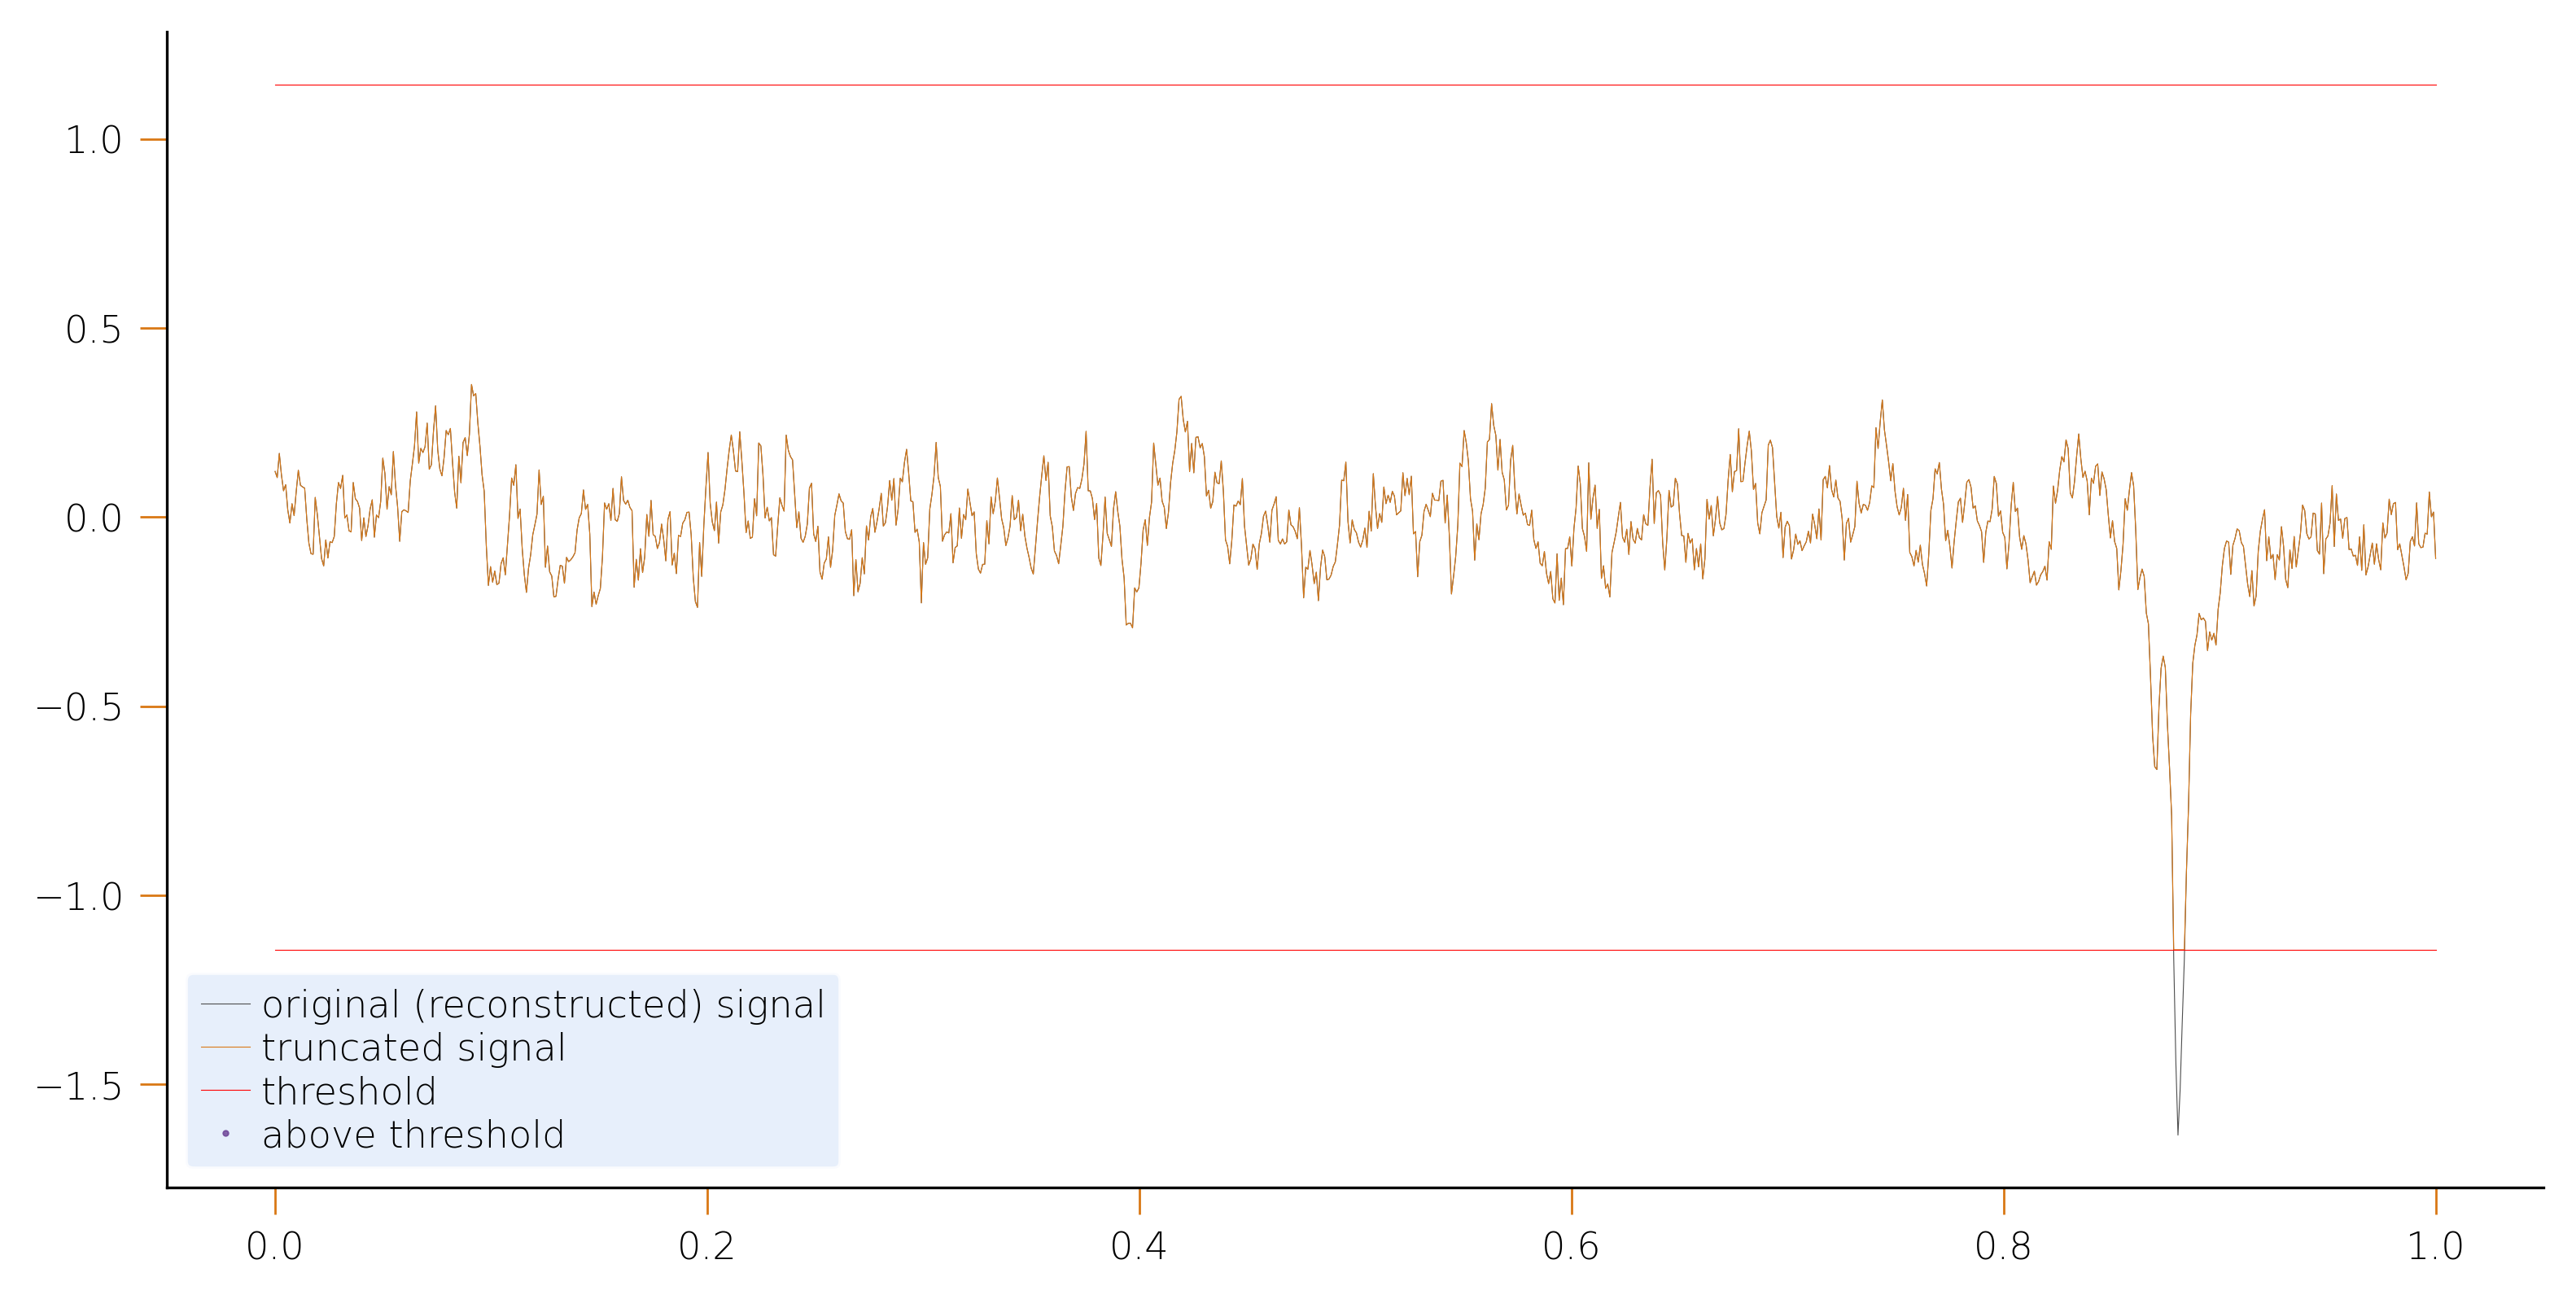

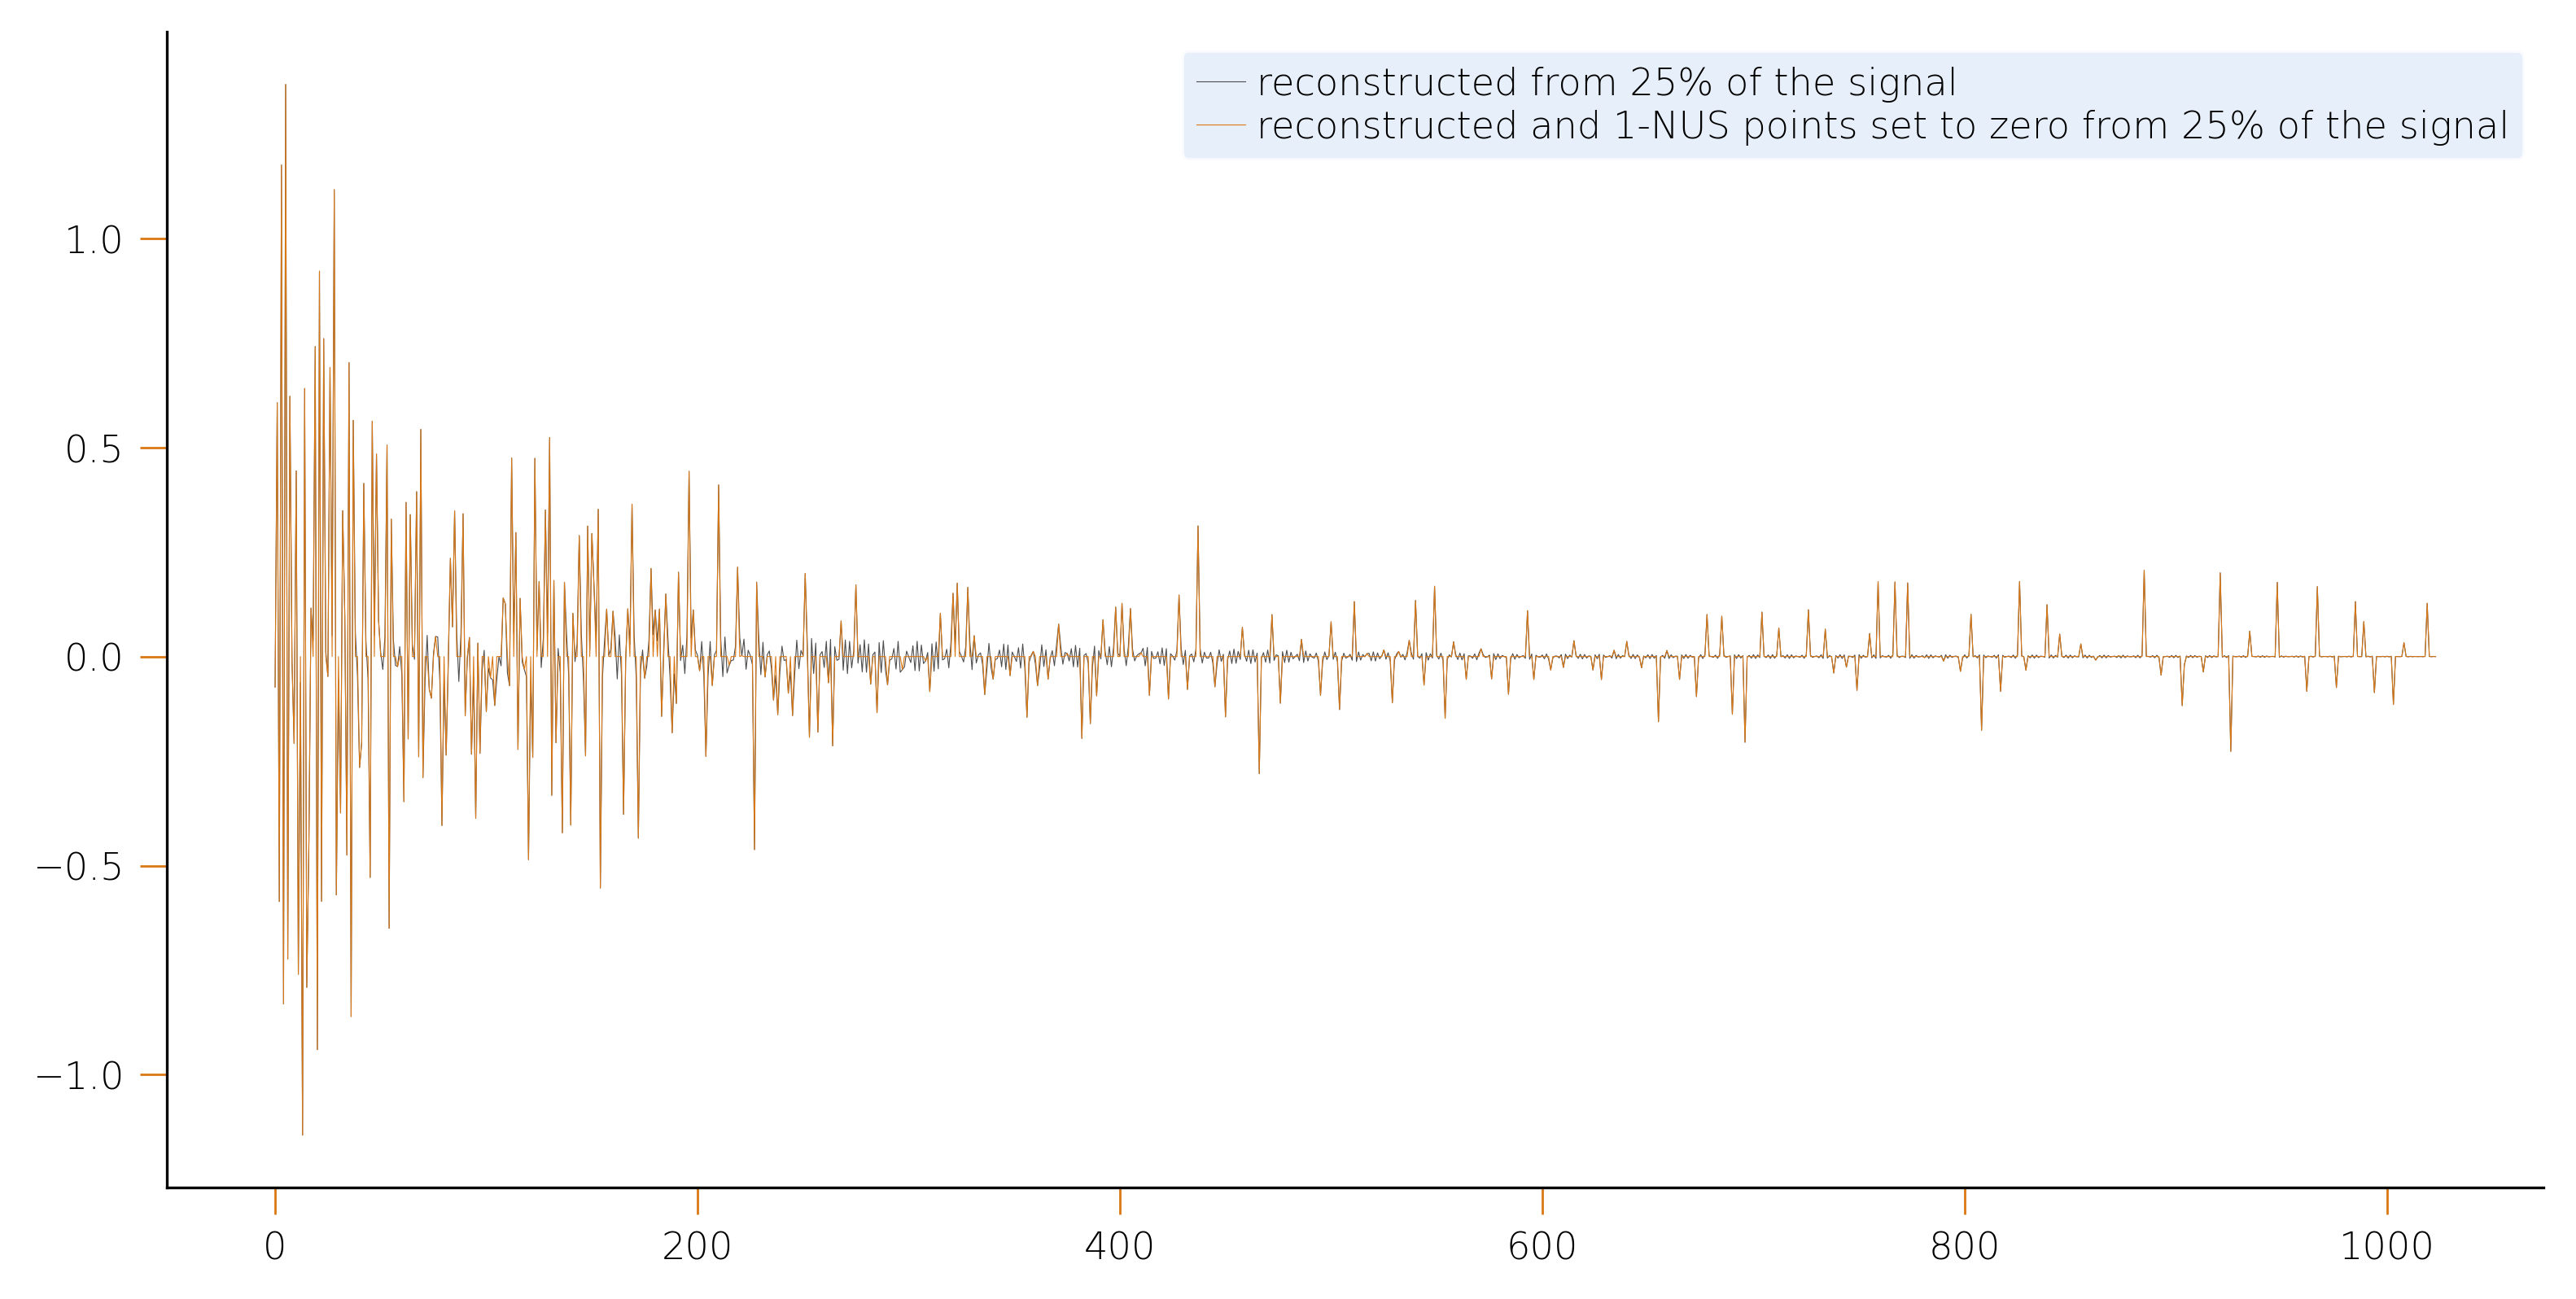

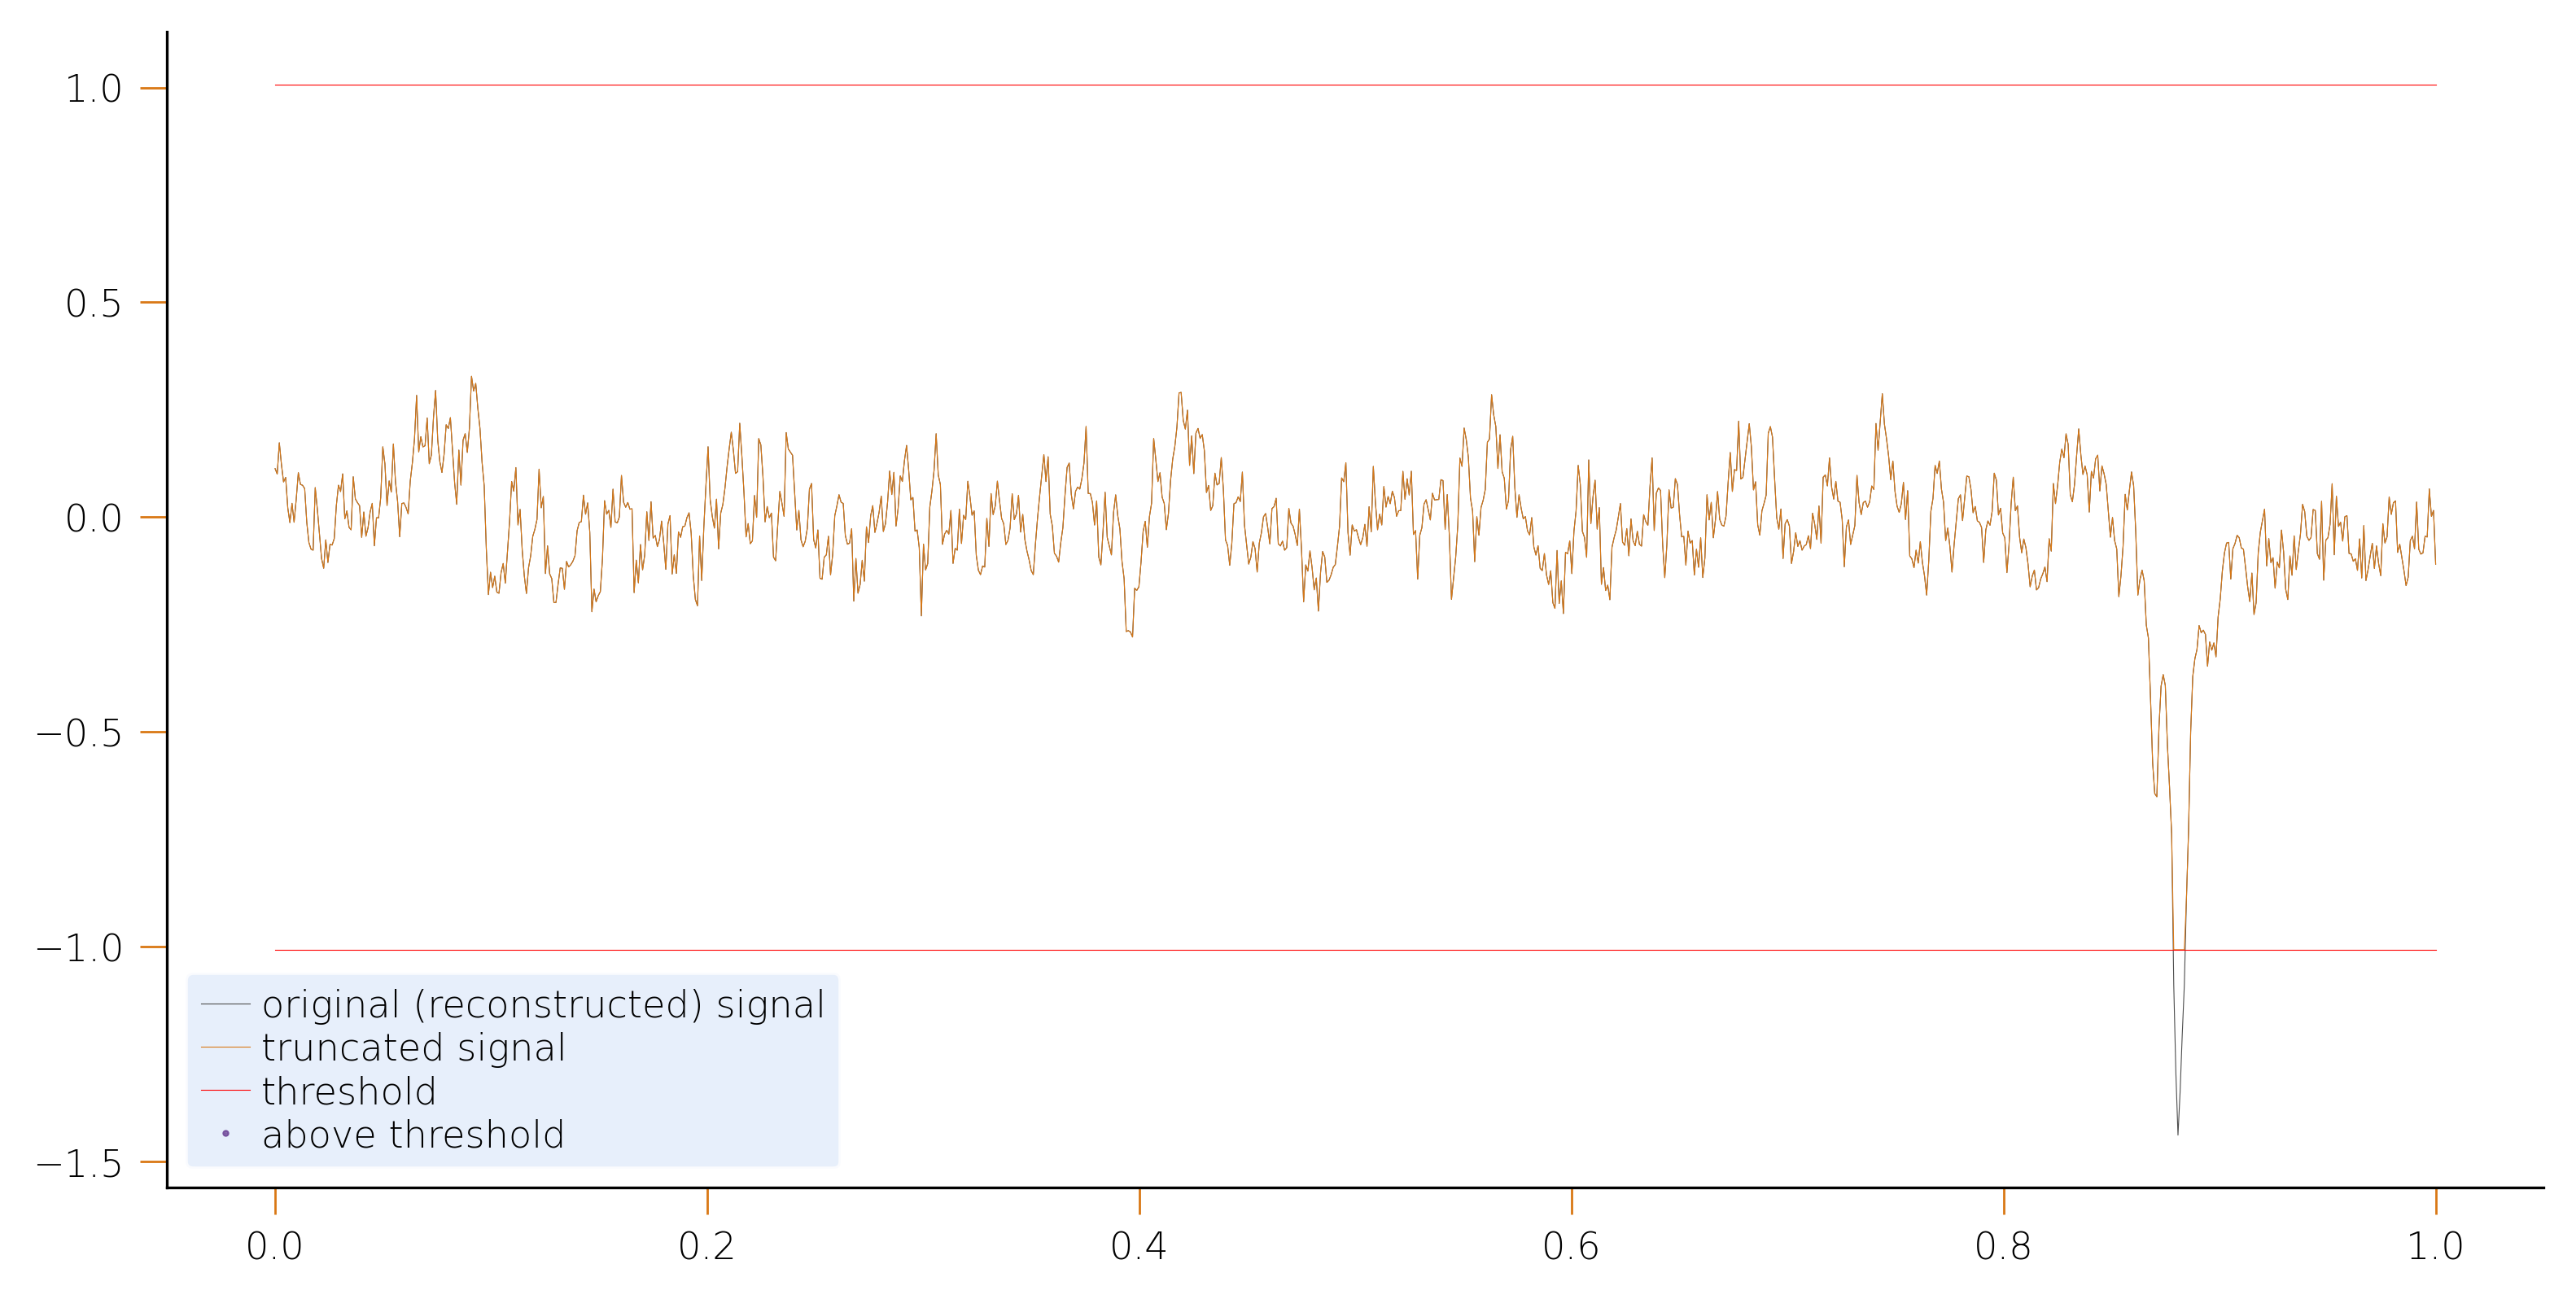

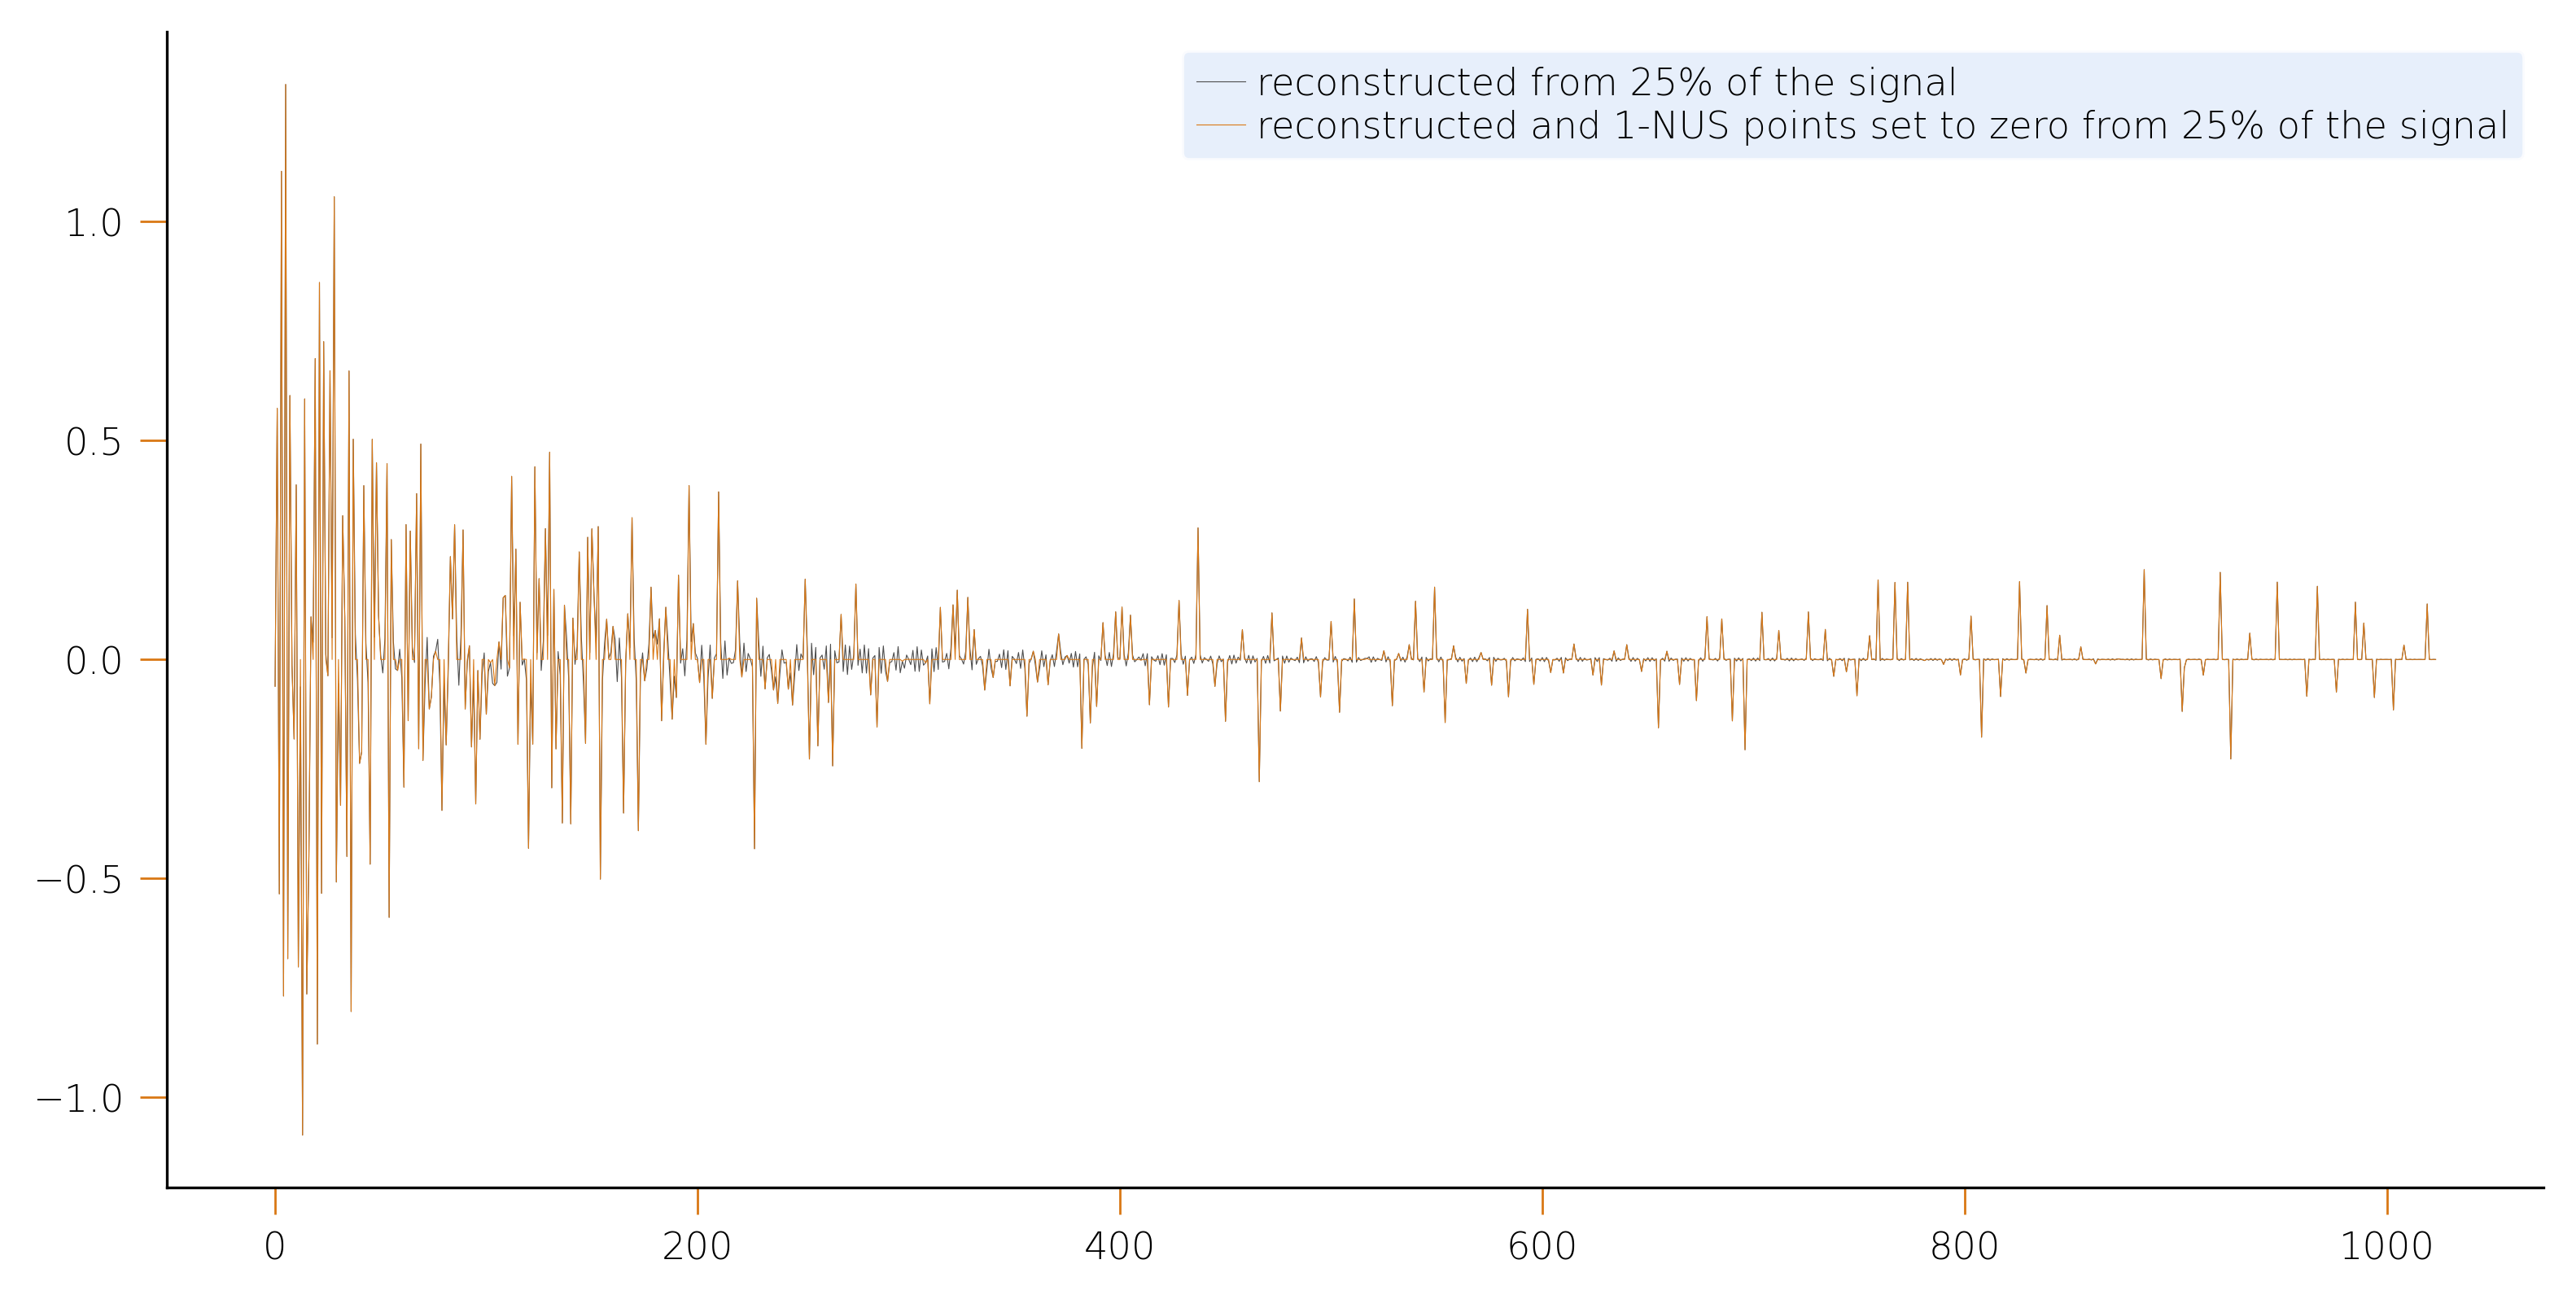

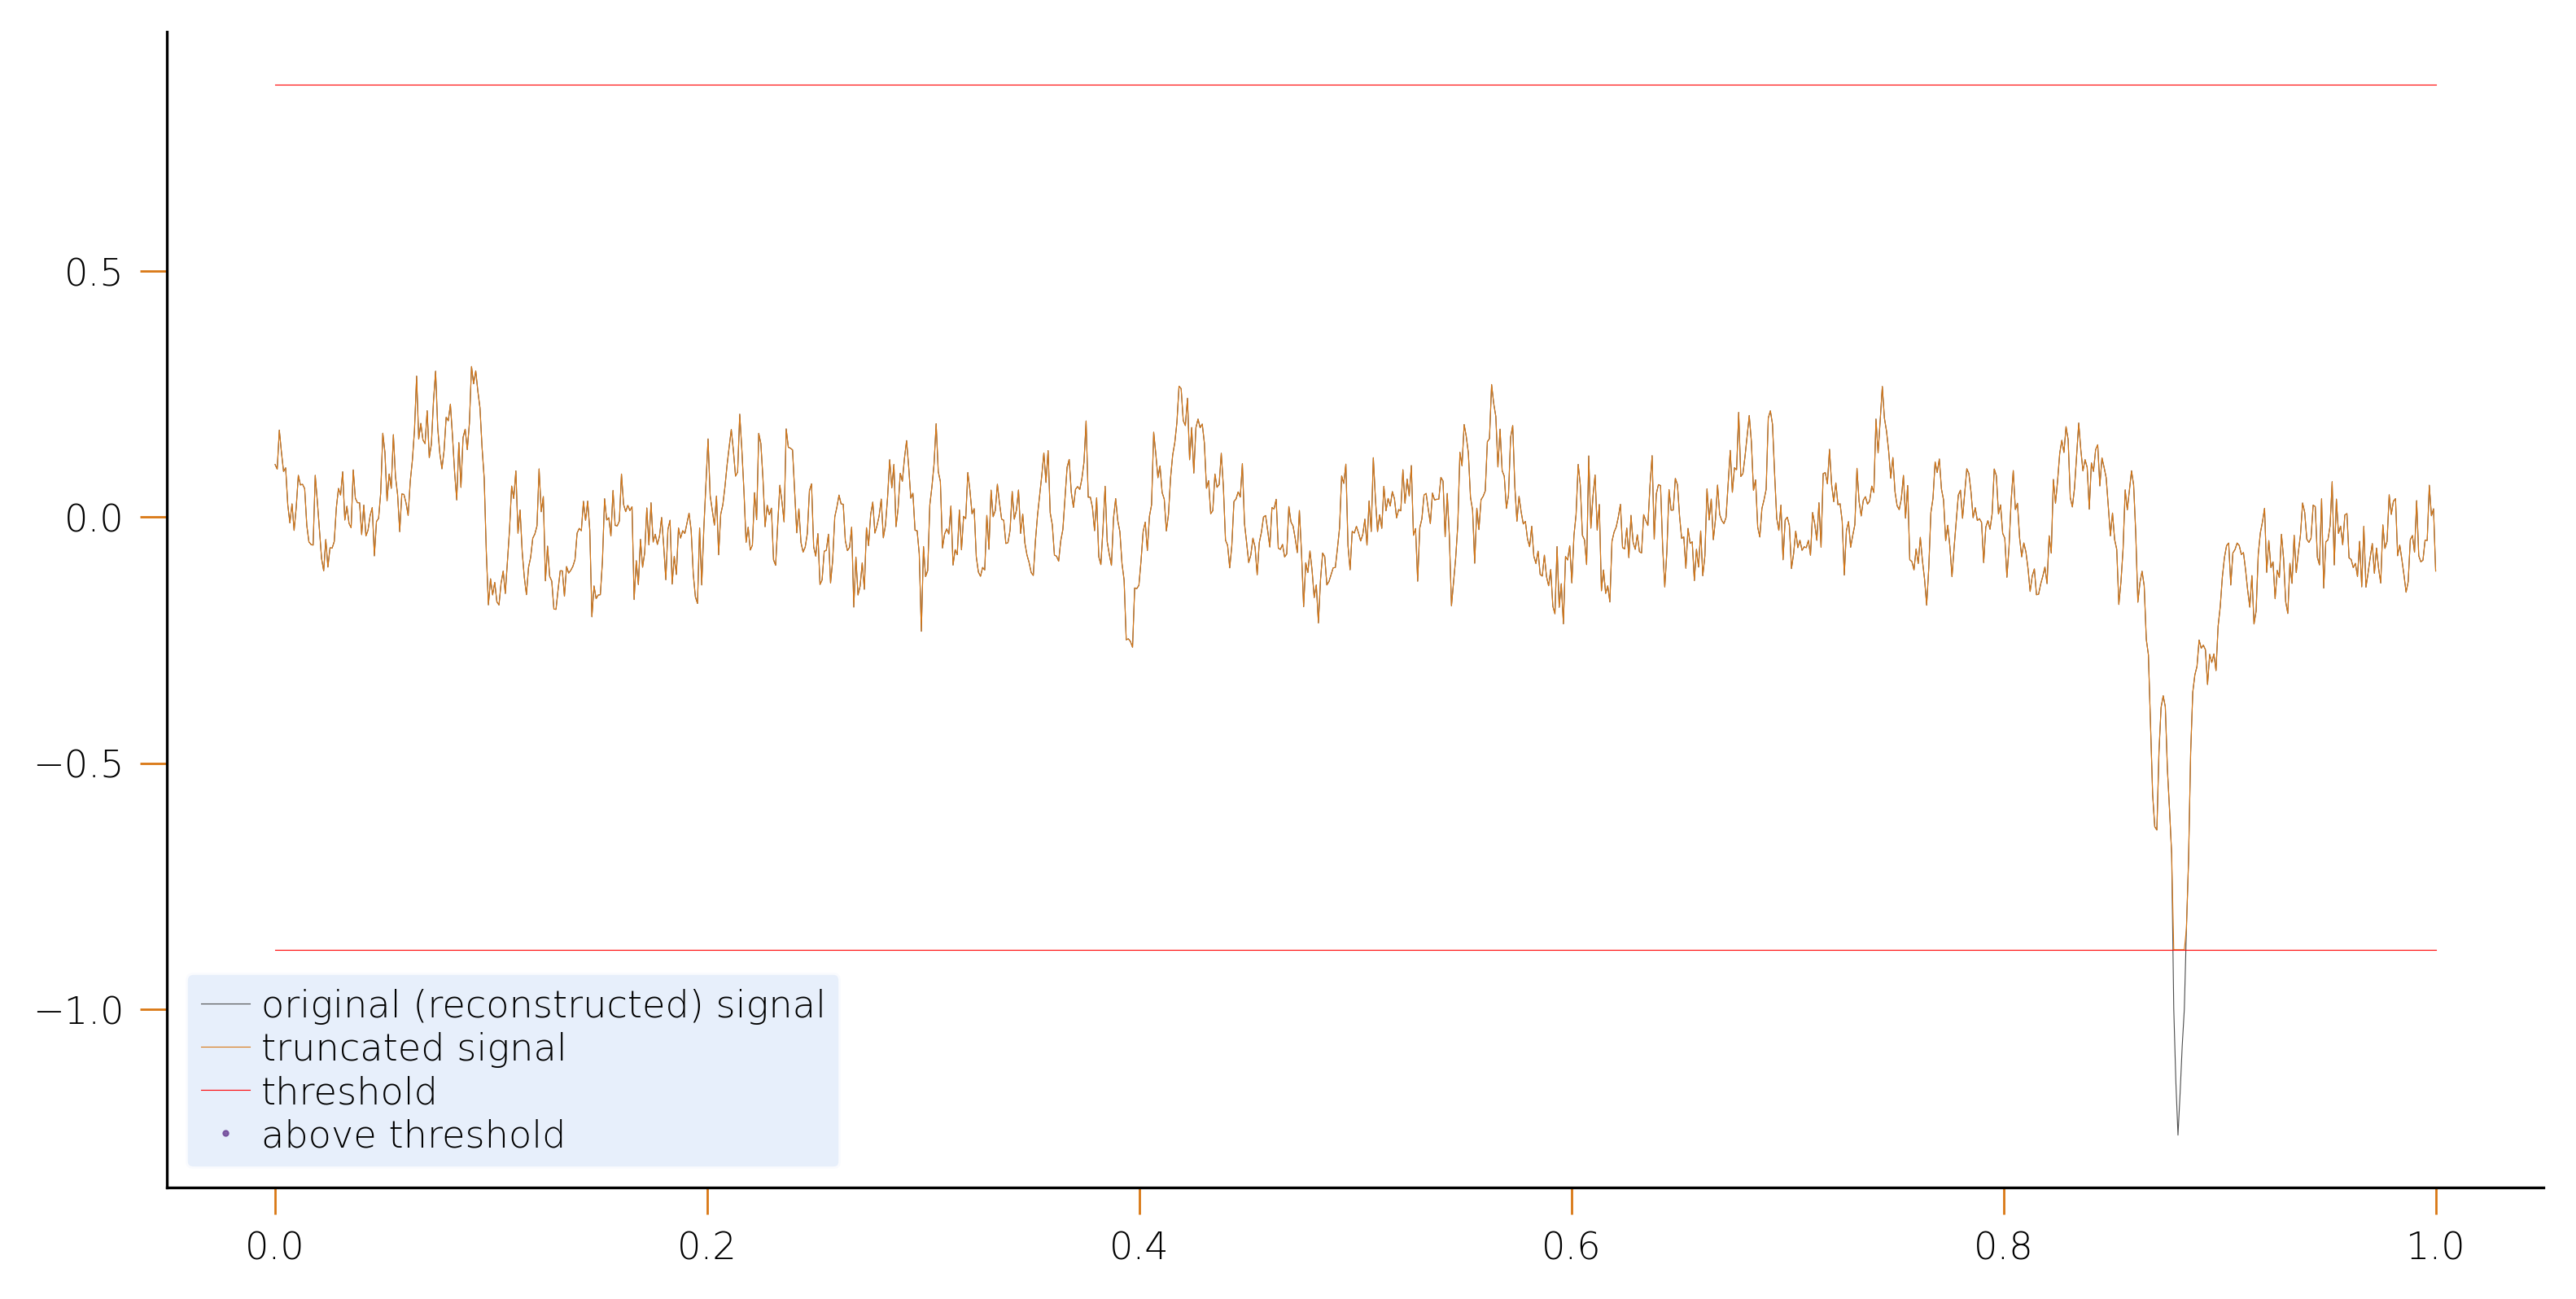

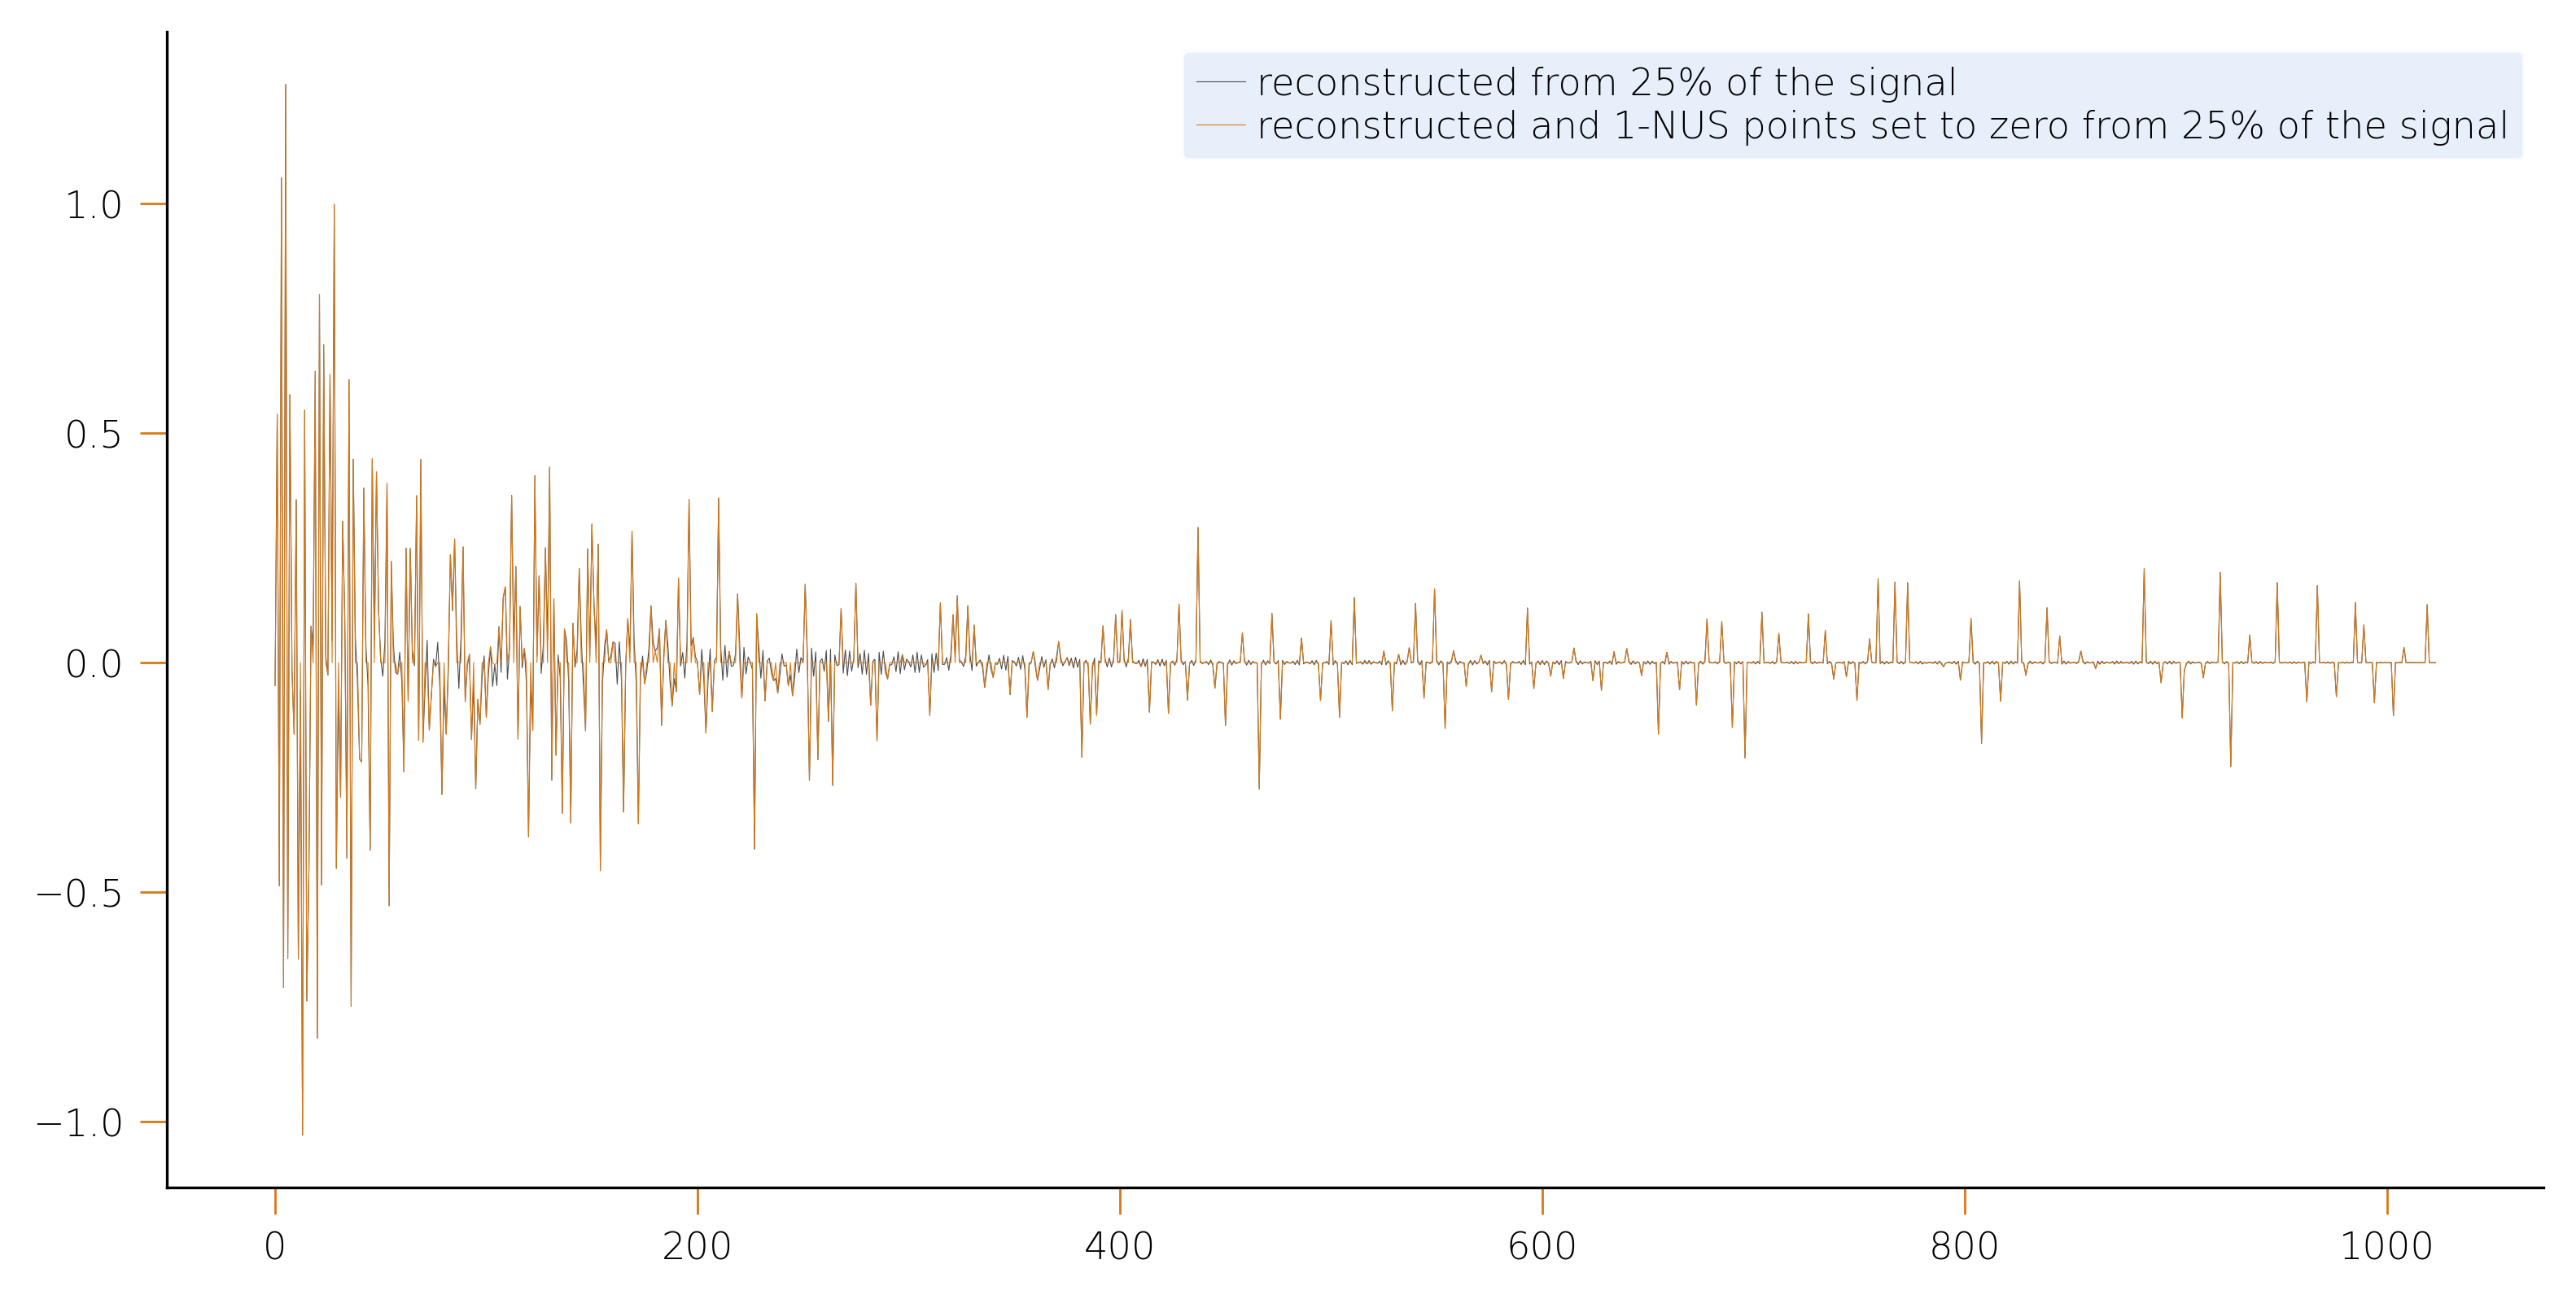

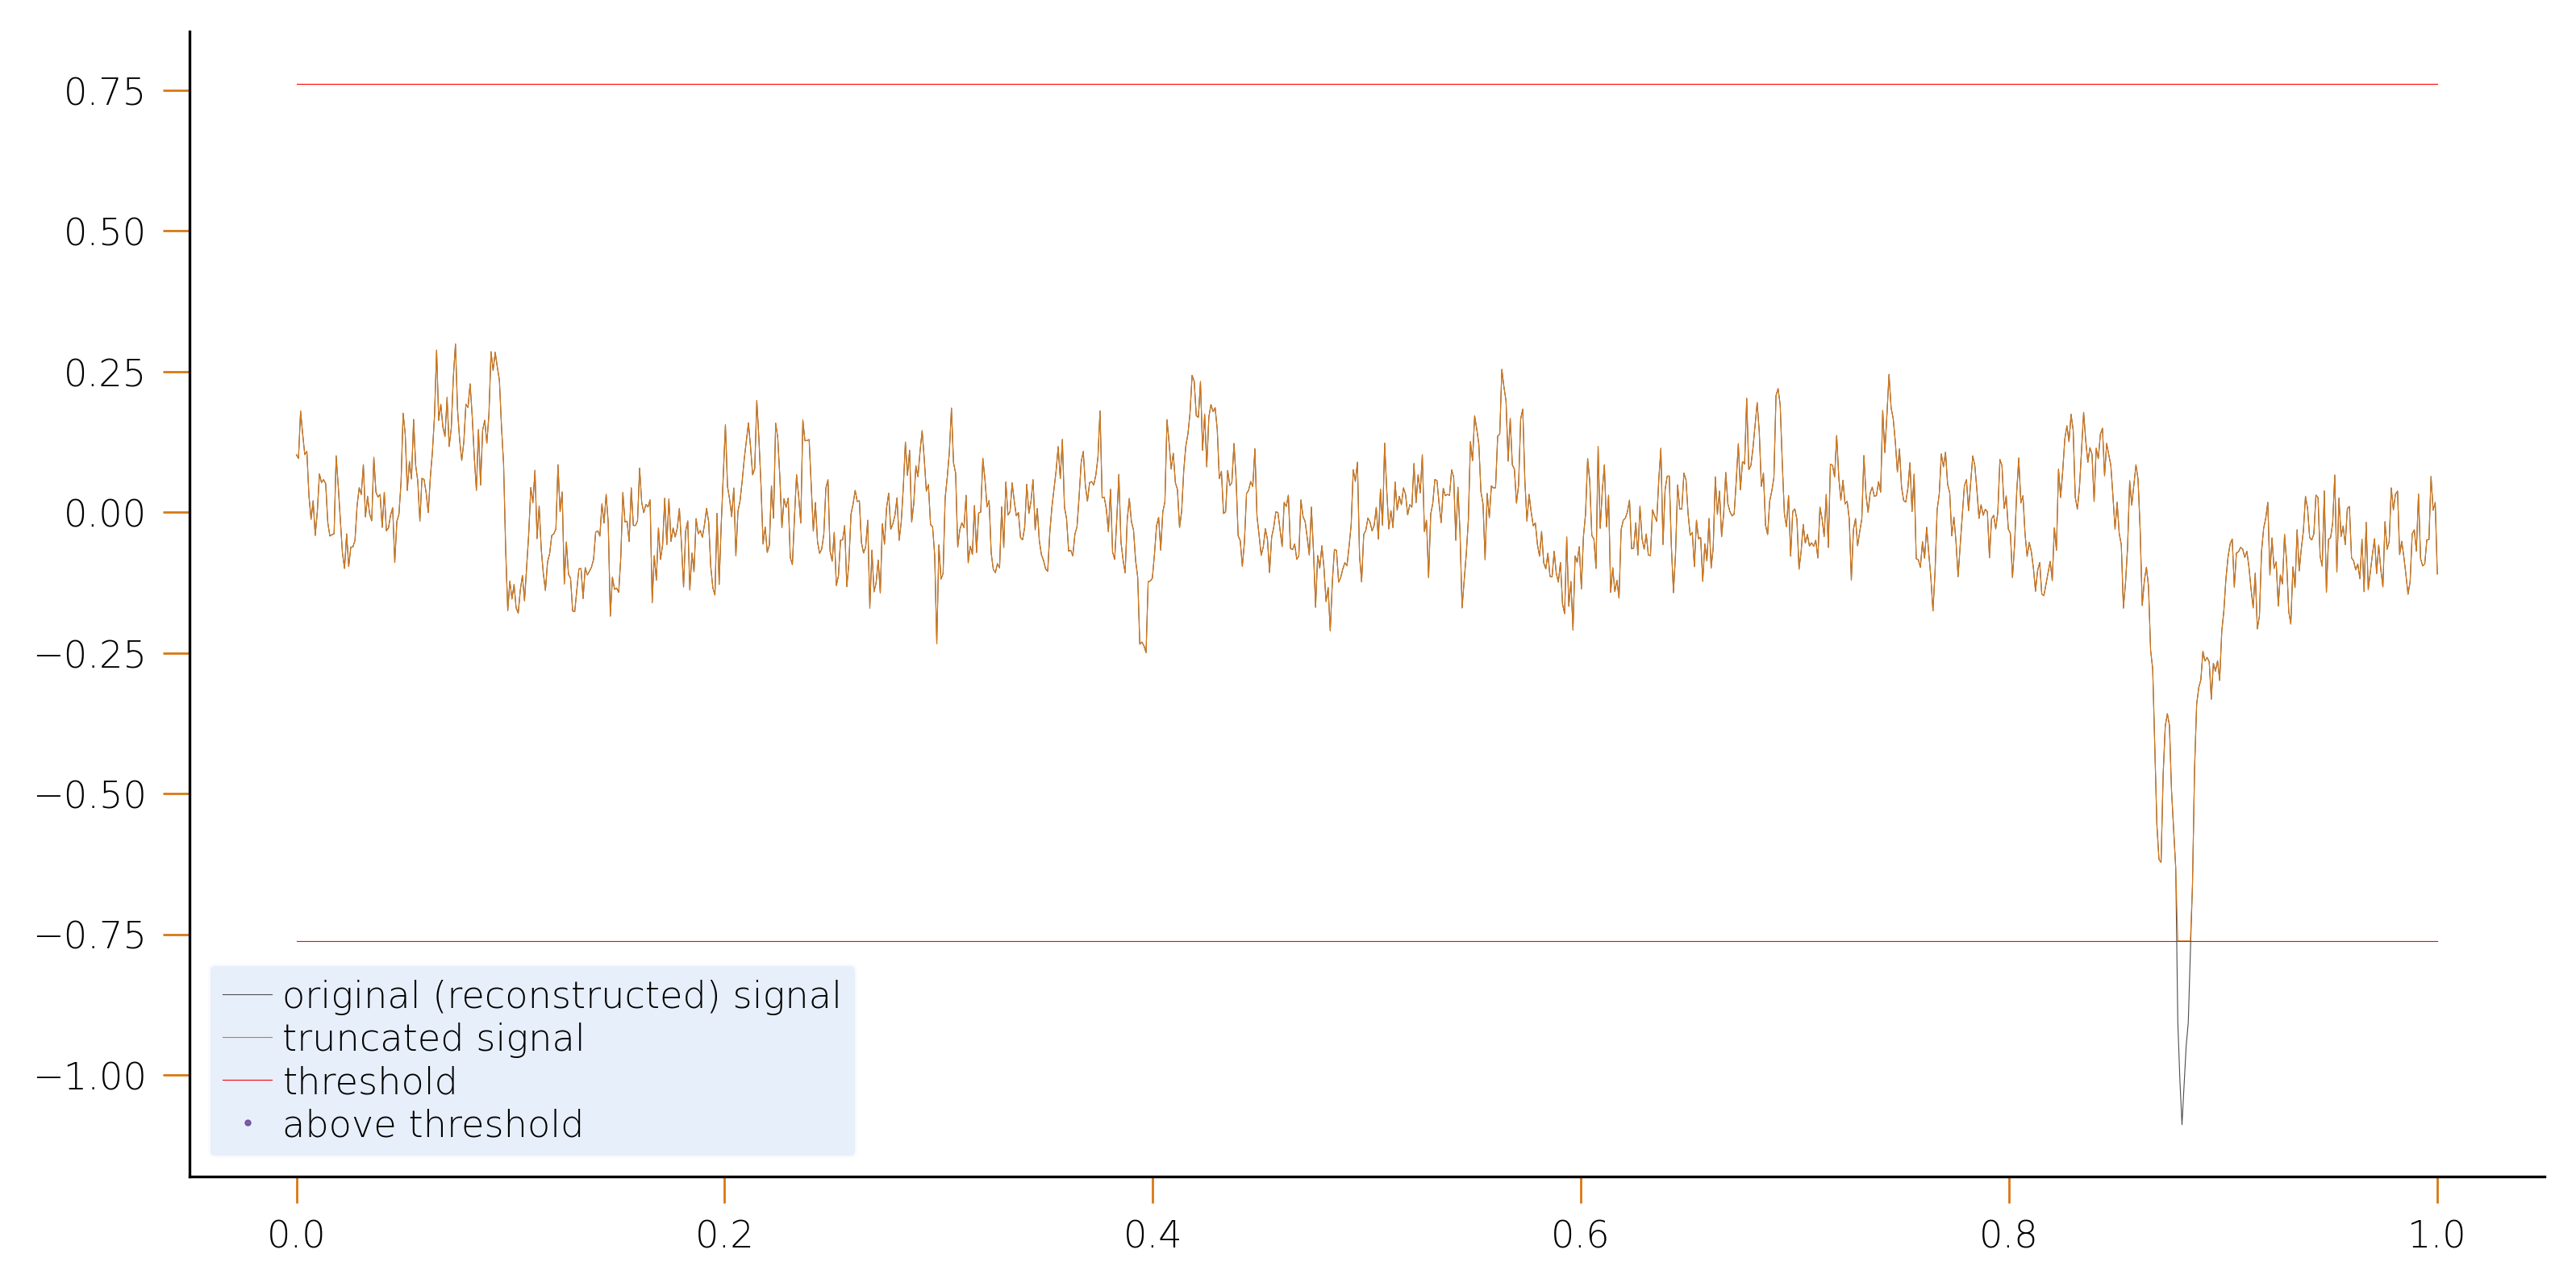

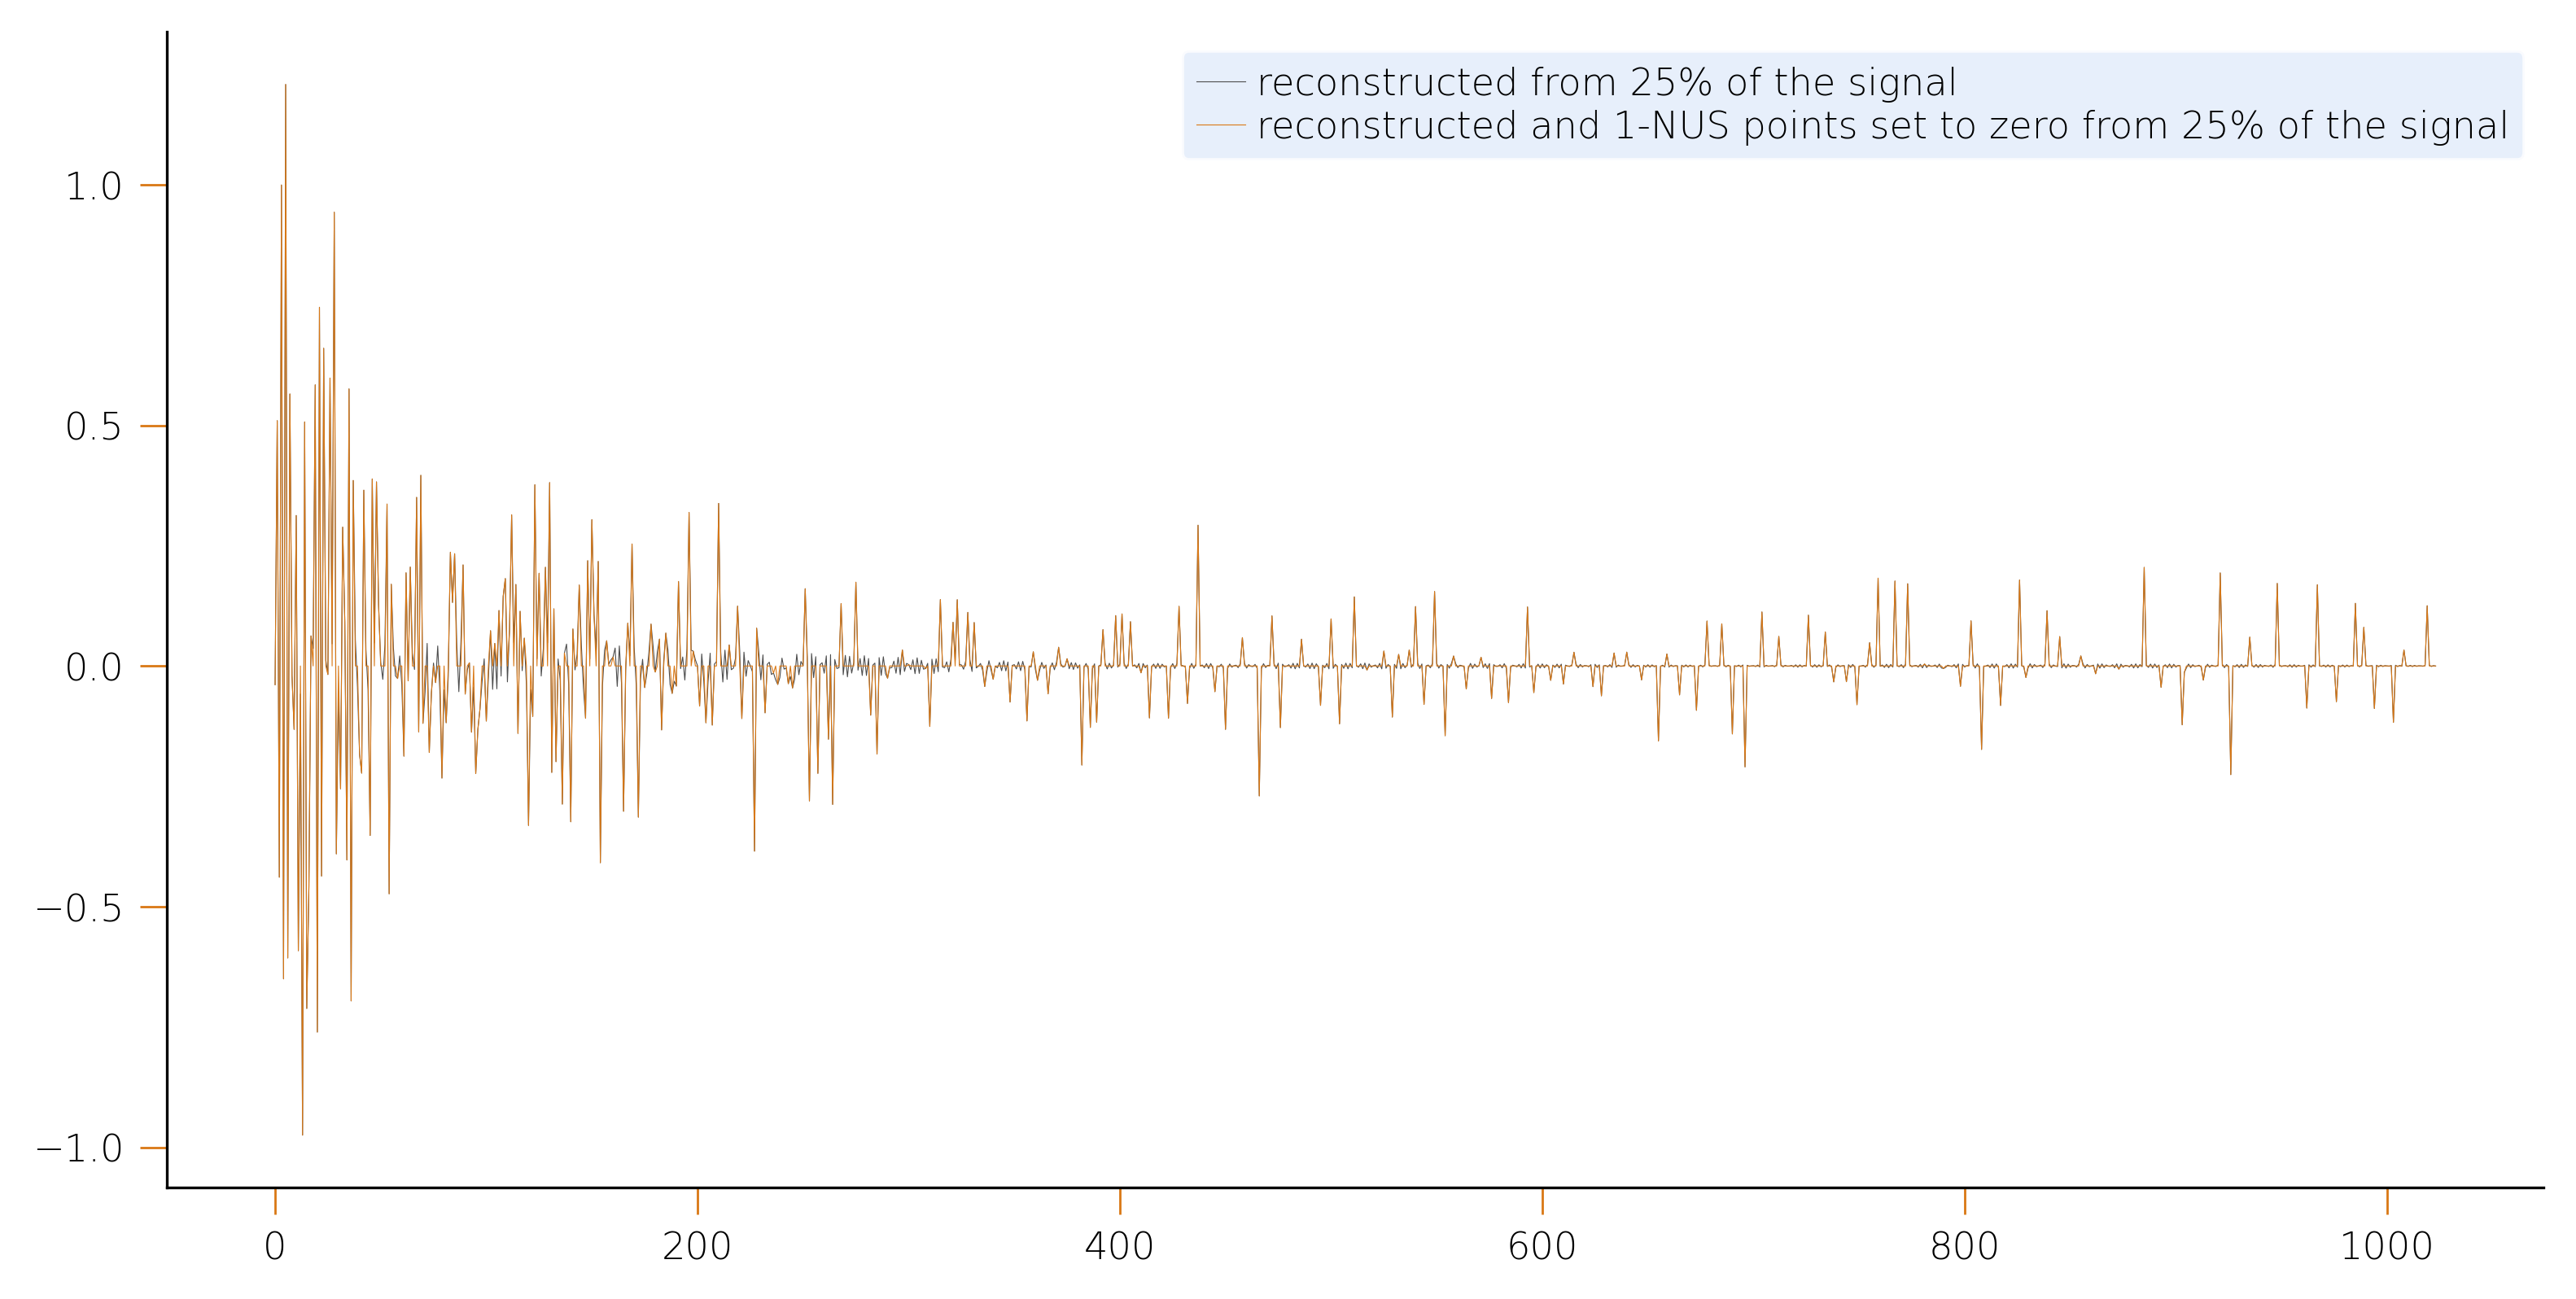

In [ ]:
# here we try to implement the iterative soft thresholding (IST) algorithm
# we use the IST algorithm to solve the problem of compressed sensing

#take the last result


subsignal = subsignal_set_padded[-1]
non_measured_indices = [i for i in range(n_t) if i not in index_set[-1]]
# real_result = results_set[-1].copy()
# result = np.abs(real_result)
#plt.plot(t, np.abs(result), linewidth=.2, label='reconstructed from '+str(percentages[-1])+'% of the signal')

#make a new empty array called "new_spectrum " with size of result



decrease = 0.7
max_iter = 5
epsilon_to_stop = 1e-5

go_on = True
print(len(non_measured_indices),'=',n_t-len(index_set[-1]))

do_plot = True
# IST algorithm
#first dct on the subsignal


real_result = spfft.dct(subsignal, norm='ortho', axis=0)

new_spectrum = np.zeros(len(real_result))
steps = 0
while go_on:     
    steps+=1 
    temp_spectrum = np.zeros(len(real_result))
    
    #take the max value of the signal
    max_value = np.max(np.abs(real_result))
    #print(max_value)
    #identify the threshold from the max values as 0.75*max_value
    threshold = decrease*max_value
    print('thr:',threshold,end='\t')
    #plot an horizontal line at the threshold
    if do_plot:
        fig = plt.figure(figsize=(10,5))
        plt.plot(t, real_result, linewidth=.2, label='original (reconstructed) signal')
    indices_to_cut = []
    for i,data_point in enumerate(real_result):
        #sign of data_point
        sign = np.sign(data_point)
        if abs(data_point)>threshold:
            indices_to_cut.append(i)
            new_spectrum[i] += abs(data_point) - threshold
            temp_spectrum[i] = data_point
            real_result[i] = sign*threshold

    # indices_threshold = t[np.where(result>threshold)]
    
    #plot result_threshold and indices_threshold with no line, big markers and no label
    if do_plot:
        plt.plot(t, real_result, linewidth=.2, label='truncated signal')
        plt.plot([0,max(t)],[threshold,threshold], linewidth=.2, color='red', label='threshold')
        plt.plot([0,max(t)],[-threshold,-threshold], linewidth=.2, color='red')
        plt.plot(t[temp_spectrum>threshold],temp_spectrum[temp_spectrum>threshold],
         linewidth=.2, marker='o',markersize=1, linestyle='None', label='above threshold')
        
        plt.legend()
        #plt.xlim(0,0.2)

    #convert the real_result to a time-domain signal using the idct
    sig_ist = spfft.idct(real_result, norm='ortho', axis=0)
    if do_plot:
        fig = plt.figure(figsize=(10,5))
        plt.plot(sig_ist, linewidth=.2, label='reconstructed from '+str(percentages[-1])+'% of the signal')
    sig_ist[non_measured_indices]=0
    if do_plot:
        plt.plot(sig_ist, linewidth=.2, label='reconstructed and 1-NUS points set to zero from '+str(percentages[-1])+'% of the signal')
        plt.legend()
    #convert sig_ist back to a spectrum
    real_result = spfft.dct(sig_ist, norm='ortho', axis=0)

    if threshold<epsilon_to_stop:
        print('Reason to stop: threshold<'+str(epsilon_to_stop))
        go_on = False

    if steps>max_iter:
        print('Steps>'+str(max_iter))
        go_on = False


In [ ]:
# 
